In [99]:
wt_indep_and_frame1_scores = "GGAGCCCATGAGAACTCTAACCGGGCTTACGGCTCCAGCACCATCAACTACACGACGATAAACTACTACCGAGACTCTGCTAGCAACGCTGCGTCTAAGCAGGACTTTAGCCAGGACCCGAGCAAGTTCACGGAGCCGATTAAGGATGTATTAATCAAAACCGCTCCTATGCTGAACAGCCCTAACATCGAGGCTTGTGGCTACTCGGACCGAGTGTTACAGCTGACTCTGGGGAATTCGACGATAACCACGCAGGAGGCGGCTAATAGCGTAGTAGCGTACGGCCGCTGGCCAGAATATCTGCGAGACAGTGAGGCTAACCCAGTAGACCAGCCAACGGAGCCTGACGTAGCTGCCTGCCGCTTCTACACCCTCGACACGGTGTCTTGGACGAAAGAGAGCCGAGGCTGGTGGTGGAAGCTGCCAGACGCCTTACGAGACATGGGGCTCTTTGGCCAAAACATGTATTACCATTACCTGGGCCGCAGCGGGTACACGGTACATGTGCAGTGTAACGCCAGTAAGTTCCATCAGGGAGCGTTGGGTGTGTTTGCGGTCCCGGAAATGTGCCTGGCGGGAGACTCCAACACCACGACTATGCACACGTCTTATCAGAACGCCAACCCTGGAGAGAAAGGTGGGACTTTCACGGGCACCTTCACGCCGGATAACAACCAGACCAGTCCAGCCCGACGCTTCTGTCCAGTGGACTACCTCCTGGGTAACGGAACCCTGCTGGGGAATGCGTTTGTCTTTCCTCACCAGATAATAAACCTGCGGACCAACAACTGTGCGACCCTTGTGTTACCGTACGTAAACAGCCTCTCGATAGACTCTATGGTGAAACACAACAACTGGGGGATAGCGATCCTGCCTCTGGCTCCTCTGAACTTCGCCTCTGAGTCTTCTCCTGAGATACCTATAACGTTAACGATAGCCCCAATGTGCTGTGAGTTTAACGGGCTGCGCAACATTACCCTGCCACGGCTGCAAGGCCTGCCGGTAATGAACACCCCTGGATCCAACCAGTACCTGACGGCGGACAACTTCCAGAGCCCATGTGCGTTACCAGAATTCGACGTGACCCCACCAATAGACATCCCAGGCGAGGTAAAGAACATGATGGAGCTGGCGGAAATAGACACGATGATCCCATTCGACCTGTCGGCGACGAAAAAGAACACCATGGAAATGTACCGAGTGCGACTGAGCGATAAGCCTCACACTGATGACCCGATACTGTGTCTTAGCCTTAGCCCAGCTTCGGACCCACGCCTCTCCCACACCATGCTGGGAGAGATATTAAACTACTATACCCACTGGGCTGGCAGCCTCAAGTTTACCTTCCTCTTCTGTGGATCGATGATGGCTACGGGGAAACTGCTTGTGTCGTATGCGCCGCCTGGCGCGGACCCTCCGAAAAAACGCAAAGAAGCGATGCTGGGGACCCATGTGATTTGGGATATAGGGCTCCAGAGCAGCTGTACCATGGTGGTGCCATGGATAAGCAACACGACCTATCGCCAGACGATAGACGATAGCTTCACCGAAGGTGGCTACATCAGCGTGTTTTATCAGACCCGCATAGTGGTGCCACTTTCGACCCCGCGAGAGATGGACATCCTGGGCTTCGTAAGCGCCTGTAATGACTTCTCCGTACGACTGCTGCGAGACACCACGCATATAGAGCAGAAAGCCCTGGCTCAGGGGCTGGGGCAGATGCTGGAAAGCATGATAGACAACACCGTGCGAGAGACCGTAGGAGCGGCGACCAGCCGGGATGCGTTACCCAACACGGAGGCTTCTGGCCCCACGCATAGCAAGGAAATCCCTGCCTTGACGGCCGTGGAGACCGGAGCCACGAACCCACTGGTGCCTTCGGACACCGTGCAGACCCGGCATGTAGTGCAGCATCGGAGCCGGAGTGAGTCTTCGATAGAGAGCTTCTTTGCCCGCGGGGCTTGTGTAACCATAATGACTGTGGACAACCCTGCCAGCACCACGAACAAGGACAAACTCTTCGCTGTGTGGAAGATTACCTACAAGGATACCGTGCAGTTACGCCGGAAGCTTGAGTTCTTCACGTACAGCCGATTCGACATGGAACTCACCTTCGTGGTAACGGCTAACTTCACTGAGACCAACAATGGCCATGCTCTTAACCAGGTGTACCAGATAATGTATGTACCTCCGGGGGCGCCAGTGCCTGAAAAGTGGGATGACTACACCTGGCAGACCAGCTCGAACCCTTCGATATTCTACACGTATGGGACGGCTCCTGCGCGAATTAGCGTACCGTATGTGGGGATATCGAACGCCTACAGCCATTTCTACGACGGCTTCAGCAAAGTGCCTCTGAAAGACCAGTCTGCGGCTCTGGGAGACTCGCTGTATGGGGCTGCTTCCTTGAACGACTTCGGCATCTTAGCCGTGCGCGTAGTAAACGACCATAACCCTACCAAGGTGACGAGTAAGATACGGGTGTACCTTAAGCCTAAGCACATACGGGTGTGGTGCCCGCGGCCGCCGCGCGCGGTAGCGTATTACGGCCCTGGGGTAGACTACAAGGACGGCACGCTCACGCCTCTCAGTACCAAGGACTTAACGACCTAC"
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))
print("CAI of the wt_indep_frame1_score_sequence is: " + str(get_cai(wt_indep_and_frame1_scores)))

CAI of the original sequence is: 0.735171695523
CAI of the recoded sequence is: 0.567416802293
CAI of the wt_indep_frame1_score_sequence is: 0.738201041275


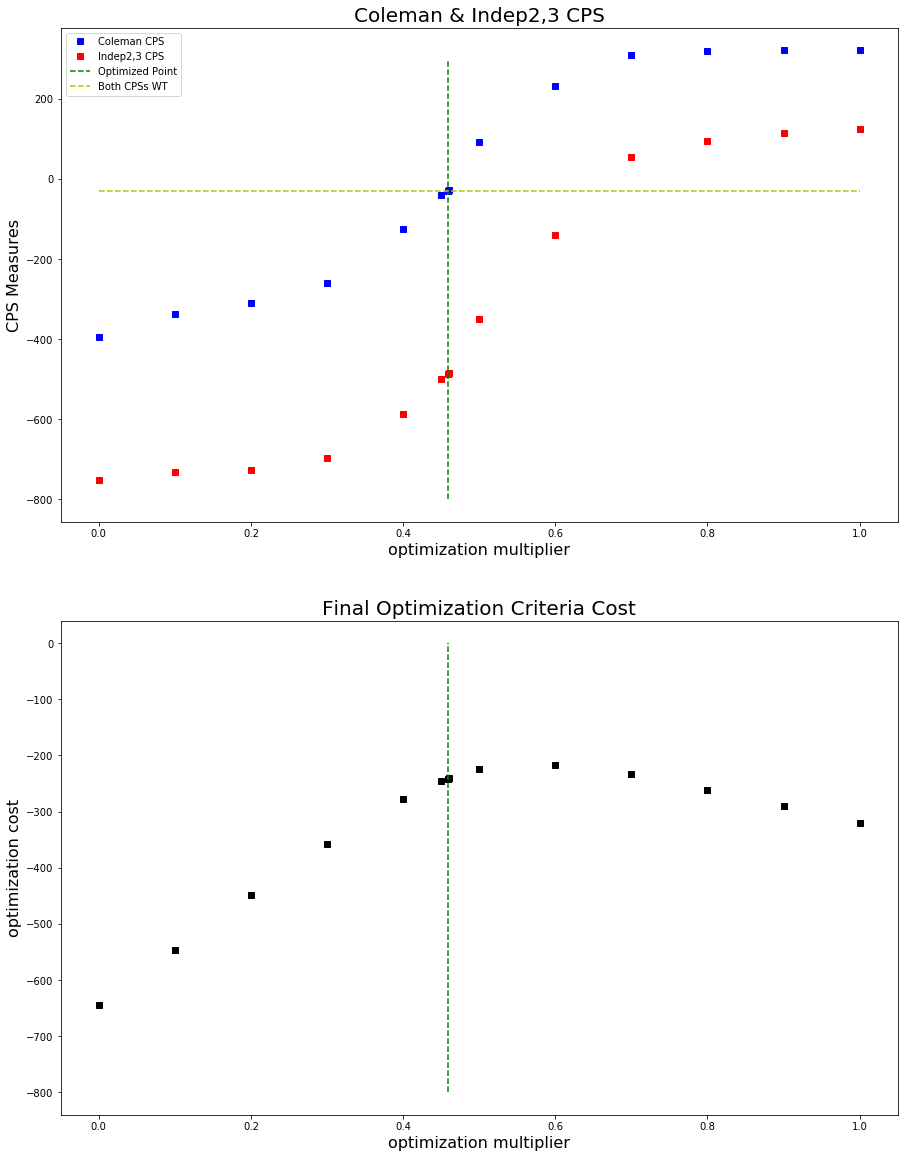

In [96]:
#coleman codon pair score of the original sequence: -30.52999999999996
#frame2&3 indep codon pair score of the original sequence: -31.61352552200005
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import subplot

coeff = [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.459,   0.46, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
coleman = [-394, -337, -311, -261, -126, -41, -31,   -27, 91, 231, 310, 318, 321.1, 321.3]
indep = [-751, -732, -726, -697, -586, -500, -488,   -484, -350, -140, 54, 95, 114, 125]
optimization_cost = [-645, -546, -449, -357, -277, -246,-242,  -241, -225, -217, -234, -261, -291, -321]

plt.figure(1, figsize=(15, 20))
plt.subplot(2,1,1)
coleman_h, = plt.plot(coeff, coleman, 'bs', label = "Coleman CPS")
indep_h, = plt.plot(coeff, indep, 'rs', label = "Indep2,3 CPS")
optimal_h, = plt.plot([0.459, 0.459], [-800, 300], 'g--', label="Optimized Point")
wt_h, = plt.plot([0, 1], [-30, -30], 'y--', label="Both CPSs WT")

#plt.plot([0, 1], [-488, -488], 'k--', label="_not in legend")


plt.legend(handles=[coleman_h, indep_h, optimal_h, wt_h])

plt.xlabel('optimization multiplier', fontsize=16)
plt.ylabel('CPS Measures', fontsize=16)
plt.title("Coleman & Indep2,3 CPS", fontsize=20)

plt.subplot(2,1,2)
plt.plot(coeff, optimization_cost, 'ks')
plt.xlabel('optimization multiplier', fontsize=16)
plt.ylabel('optimization cost', fontsize=16)
optimal_h, = plt.plot([0.459, 0.459], [-800, 0], 'g--', label="Optimized Point")
plt.title("Final Optimization Criteria Cost", fontsize=20)

plt.show()

In [70]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats

def get_cps(seq):
    cps = 0
    num_pairs = 0
    for i in range(0,(len(seq)-6),3):
        num_pairs += 1
        cps += cp_scores[seq[i:i+6]]
    return(cps)

def get_cpb(seq):
    cps = 0
    num_pairs = 0
    for i in range(0,(len(seq)-6),3):
        num_pairs += 1
        cps += cp_scores[seq[i:i+6]]
    #print(num_pairs)
    #print(cps)
    return((cps/num_pairs) )

# codon pair score of any length sequence
def get_cps_indep(seq):
    cps_indep = 0 
    # for indep_dependent pairs scores - frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    # for indep_dependent pairs scores - frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    return(cps_indep)


def num_costly_codon_pairs(seq):
    num_indep = 0
    # now do the independent scoring, frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    # now do the independent scoring, frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    return(num_indep)

# codon pair score of any length sequence, only using OUR pairs
def get_cps_indep_only_our_bad_pairs(seq):
    cps_indep = 0 
    # for indep_dependent pairs scores - frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        if (seq[i:i+6] not in pairs_to_maximize_indep): # skip if not our bad pairs
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    # for indep_dependent pairs scores - frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        if (seq[i:i+6] not in pairs_to_maximize_indep): # skip if not our bad pairs
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    return(cps_indep)

# codon adaptation index of any length sequence
def get_cai(seq):
    # get the CAI as the geometric mean of all the codon's individual CAI values
    cai_list = []
    for i in range(0,len(seq),3):
        cai_list.append(codon_CAI[seq[i:(i+3)]])
    return(scistats.gmean(cai_list))

# read in synonymous codons
aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]

# read in the human orfs and make the CAI for all the codons
codon_occs = dict()
# set up the dict
for codon in (codon_to_aa_dict.keys()):
    codon_occs[codon] = 0
genes_file = open("human_CCDS_nucleotide.current.fna")
for line in genes_file:
    line = line.rstrip()
    if line[0] != ">": 
        if (len(line)%3 != 0):
            #print("PROBLEM, genes file is not multiple of 3 per line.")
            continue
        # get the frequency of each codon
        for i in range(0,len(line),3):
            codon_occs[line[i:(i+3)]] += 1

# get the CAI of each codon
codon_CAI = dict()
for aa in (aa_to_syn_codons_dict.keys()):
    highest_frequency = 0
    for codon in (aa_to_syn_codons_dict[aa]):
        if (codon_occs[codon] > highest_frequency):
            highest_frequency = codon_occs[codon]
    for codon in (aa_to_syn_codons_dict[aa]):
        if (highest_frequency == 0):
            codon_CAI[codon] = 0
        else:
            codon_CAI[codon] = codon_occs[codon]/highest_frequency
            

# read in the gene's codon sequence
codons_file = open("polio_genomics.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

print("original codons")
print(original_codons)
#original_codons = "GGCGCACATGAA"

original_AA = ""
for i in range(0,len(original_codons),3):
    original_AA += codon_to_aa_dict[original_codons[i:i+3]]

#print(original_AA)

m = 0.459

# store_best will contain, at each AA position, and at each of the syn codon choices, and the following AA's
# syn codon choices, 
# the best cost of the prefix that starts with this codon, the current codon pair score,
# and the next codon that corresponds to this cost
store_best = [None] * (len(original_AA)-1)
for i in range(0,len(original_AA)-1):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = dict()
        for codon_next in aa_to_syn_codons_dict[original_AA[i+1]]:
            store_best[i][codon][codon_next] = 0
            
# initialize the dynamic program by setting store_best for the first amino acid position
for codon in store_best[0]:
    for codon_next in store_best[1]:
        store_best[0][codon][codon_next] = (0,0,"",codon)

# do the dynamic program, starting from the beginning
for pos in range(1, len(store_best)):
    for codon in store_best[pos]:
        for codon_next in store_best[pos][codon]:
            # consider as cost the cost of adding this codon to one of the best sequences
            # from the previous suffix
            best_prev = ""
            best_cps = sys.maxsize # keep this
            best_cost = sys.maxsize #-1 #sys.maxsize #-1
            best_seq = ""
            for prev_codon in store_best[pos-1]:
                #cost = store_best[pos-1][prev_codon][codon][0] + num_costly_codon_pairs(prev_codon + codon + codon_next) 
                cp_score = get_cps_indep(store_best[pos-1][prev_codon][codon][3] + codon + codon_next)
                #print(str(pos-1), " ", str(prev_codon), " ", str(codon))
                sub_seq = store_best[pos-1][prev_codon][codon][3] + codon + codon_next
                #print(sub_seq)
                indep_score = get_cps_indep_only_our_bad_pairs(sub_seq)
                classic_score = get_cps(sub_seq)
                cost = (1-m) * indep_score - m * classic_score
                #print(str(indep_score), " ", str(classic_score), " ", str(cost))
                #if ((cost > best_cost) or # > <
                    # break the tie with lowest codon pair score
                    #((cost == best_cost) and (cp_score < best_cps))):
                if (cost < best_cost):
                    best_cost = cost
                    best_cps = cp_score
                    best_prev = prev_codon
                    best_seq = store_best[pos-1][prev_codon][codon][3] + codon
            store_best[pos][codon][codon_next] = (best_cost, best_cps, best_prev, best_seq)
            #print("storing for " + str(pos) + " " + codon +  " " + codon_next + " : " + str(best_cps) + " " + best_prev + " " + best_seq)
            #GGC GCA CAT GAA

# do the final position
best_cps = sys.maxsize # keep this
best_cost = sys.maxsize #-1 #sys.maxsize #-1
best_seq = ""
for codon in aa_to_syn_codons_dict[original_AA[-1]]:
    for prev_codon in aa_to_syn_codons_dict[original_AA[-2]]:
        #cost = store_best[-1][prev_codon][codon][0]
        #print(str(pos-1), " ", str(prev_codon), " ", str(codon))
        cp_score = store_best[-1][prev_codon][codon][1]
        indep_score = get_cps_indep_only_our_bad_pairs(store_best[-1][prev_codon][codon][3] + codon + codon_next)
        classic_score = get_cps(store_best[-1][prev_codon][codon][3] + codon + codon_next)
        cost = (1-m) * indep_score - m * classic_score
        #print(cost)
        #if ((cost > best_cost) or # > <
            # break the tie with lowest codon pair score
             #((cost == best_cost) and (cp_score < best_cps))):
        if (cost < best_cost):
            best_cost = cost
            best_cps = cp_score
            best_seq = store_best[-1][prev_codon][codon][3] + codon
#print(str(best_cps) + " " + str(best_cost) + " " + best_seq)

recoded_sequence = best_seq
print("recoded sequence")
print(recoded_sequence)
print("Final Best Cost")
print(best_cost)
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
#print(len(original_codons))
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(recoded_sequence)))
print("coleman codon pair bias of the original sequence: " + str(get_cpb(original_codons)))
print("coleman codon pair bias of the recoded sequence: " + str(get_cpb(recoded_sequence)))
print("frame2&3 indep codon pair score of the original sequence: " + str(get_cps_indep(original_codons)))
print("frame2&3 indep codon pair score of the recoded sequence: " + str(get_cps_indep(recoded_sequence)))
print("coleman codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("coleman codon pair score of the recoded sequence: " + str(get_cps(recoded_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))

original codons
GGCGCACATGAAAACTCAAATAGAGCGTATGGTAGTTCTACCATTAATTACACCACCATTAATTATTATAGAGATTCAGCTAGTAACGCGGCTTCGAAACAGGACTTCTCTCAAGACCCTTCCAAGTTCACCGAGCCCATCAAGGATGTCCTGATAAAAACAGCCCCAATGCTAAACTCGCCAAACATAGAGGCTTGCGGGTATAGCGATAGAGTACTGCAATTAACACTGGGAAACTCCACTATAACCACACAGGAGGCGGCTAATTCAGTAGTCGCTTATGGGCGTTGGCCTGAATATCTGAGGGACAGCGAAGCCAATCCAGTGGACCAGCCGACAGAACCAGACGTCGCTGCATGCAGGTTTTATACGCTAGACACCGTGTCTTGGACGAAAGAGTCGCGAGGGTGGTGGTGGAAGTTGCCTGATGCACTGAGGGACATGGGACTCTTTGGGCAAAATATGTACTACCACTACCTAGGTAGGTCCGGGTACACCGTGCATGTACAGTGTAACGCCTCCAAATTCCACCAGGGGGCACTAGGGGTATTCGCCGTACCAGAGATGTGTCTGGCCGGGGATAGCAACACCACTACCATGCACACCAGCTATCAAAATGCCAATCCTGGCGAGAAAGGAGGCACTTTCACGGGTACGTTCACTCCTGACAACAACCAGACATCACCTGCCCGCAGGTTCTGCCCGGTGGATTACCTCCTTGGAAATGGCACGTTGTTGGGGAATGCCTTTGTGTTCCCGCACCAGATAATAAACCTACGGACCAACAACTGTGCTACACTGGTACTCCCTTACGTGAACTCCCTCTCGATAGATAGTATGGTAAAGCACAATAATTGGGGAATTGCAATATTACCATTGGCCCCATTAAATTTTGCTAGTGAGTCCTCCCCAGAGATTCCAATCACCTTGACCATAGCCCCTATGTGCTGTGAGTTCAATGGATTAAGAAACATCACCCTGCCA

## For Week of Sept 11.  Optimizing for Indep2,3 - m * Coleman

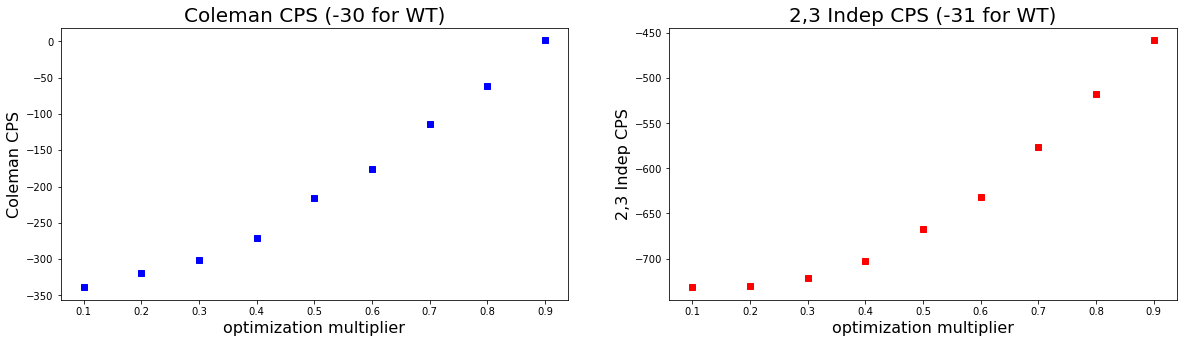

In [54]:
#coleman codon pair score of the original sequence: -30.52999999999996
#frame2&3 indep codon pair score of the original sequence: -31.61352552200005
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import subplot


coeff = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
coleman = [-339, -319, -301, -271, -216, -176, -114, -61, 1.32]
indep = [-732, -730, -722, -703, -667, -632, -576, -518, -458]

plt.figure(1, figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(coeff, coleman, 'bs')
plt.xlabel('optimization multiplier', fontsize=16)
plt.ylabel('Coleman CPS', fontsize=16)
plt.title("Coleman CPS (-30 for WT)", fontsize=20)

plt.subplot(1,2,2)
plt.plot(coeff, indep, 'rs')
plt.xlabel('optimization multiplier', fontsize=16)
plt.ylabel('2,3 Indep CPS', fontsize=16)
plt.title("2,3 Indep CPS (-31 for WT)", fontsize=20)

plt.show()

In [47]:
original_sequence = "GGCGCACATGAAAACTCAAATAGAGCGTATGGTAGTTCTACCATTAATTACACCACCATTAATTATTATAGAGATTCAGCTAGTAACGCGGCTTCGAAACAGGACTTCTCTCAAGACCCTTCCAAGTTCACCGAGCCCATCAAGGATGTCCTGATAAAAACAGCCCCAATGCTAAACTCGCCAAACATAGAGGCTTGCGGGTATAGCGATAGAGTACTGCAATTAACACTGGGAAACTCCACTATAACCACACAGGAGGCGGCTAATTCAGTAGTCGCTTATGGGCGTTGGCCTGAATATCTGAGGGACAGCGAAGCCAATCCAGTGGACCAGCCGACAGAACCAGACGTCGCTGCATGCAGGTTTTATACGCTAGACACCGTGTCTTGGACGAAAGAGTCGCGAGGGTGGTGGTGGAAGTTGCCTGATGCACTGAGGGACATGGGACTCTTTGGGCAAAATATGTACTACCACTACCTAGGTAGGTCCGGGTACACCGTGCATGTACAGTGTAACGCCTCCAAATTCCACCAGGGGGCACTAGGGGTATTCGCCGTACCAGAGATGTGTCTGGCCGGGGATAGCAACACCACTACCATGCACACCAGCTATCAAAATGCCAATCCTGGCGAGAAAGGAGGCACTTTCACGGGTACGTTCACTCCTGACAACAACCAGACATCACCTGCCCGCAGGTTCTGCCCGGTGGATTACCTCCTTGGAAATGGCACGTTGTTGGGGAATGCCTTTGTGTTCCCGCACCAGATAATAAACCTACGGACCAACAACTGTGCTACACTGGTACTCCCTTACGTGAACTCCCTCTCGATAGATAGTATGGTAAAGCACAATAATTGGGGAATTGCAATATTACCATTGGCCCCATTAAATTTTGCTAGTGAGTCCTCCCCAGAGATTCCAATCACCTTGACCATAGCCCCTATGTGCTGTGAGTTCAATGGATTAAGAAACATCACCCTGCCACGCTTACAGGGCCTGCCGGTCATGAACACCCCTGGTAGCAATCAATATCTTACTGCAGACAACTTCCAGTCACCGTGTGCGCTGCCTGAATTTGATGTGACCCCACCTATTGACATACCCGGTGAAGTAAAGAACATGATGGAATTGGCAGAAATCGACACCATGATTCCCTTTGACTTAAGTGCCACAAAAAAGAACACCATGGAAATGTATAGGGTTCGGTTAAGTGACAAACCACATACAGACGATCCCATACTCTGCCTGTCACTCTCTCCAGCCTCAGATCCTAGGTTGTCACATACTATGCTTGGAGAAATCCTAAATTACTACACACACTGGGCAGGATCCCTGAAGTTCACGTTTCTGTTCTGTGGATCCATGATGGCAACTGGCAAACTGTTGGTGTCATACGCGCCTCCTGGAGCCGACCCACCAAAGAAGCGTAAGGAGGCGATGTTGGGAACACATGTGATCTGGGACATAGGACTGCAGTCCTCATGTACTATGGTAGTGCCATGGATTAGCAACACCACGTATCGGCAAACCATAGATGATAGTTTCACCGAAGGCGGATACATCAGCGTCTTCTACCAAACTAGAATAGTCGTCCCTCTTTCGACACCCAGAGAGATGGACATCCTTGGTTTTGTGTCAGCGTGTAATGACTTCAGCGTGCGCTTGTTGCGAGATACCACACATATAGAGCAAAAAGCGCTAGCACAGGGGTTAGGTCAGATGCTTGAAAGCATGATTGACAACACAGTCCGTGAAACGGTGGGGGCGGCAACATCTAGAGACGCTCTCCCAAACACTGAAGCCAGTGGACCAACACACTCCAAGGAAATTCCGGCACTCACCGCAGTGGAAACTGGGGCCACAAATCCACTAGTCCCTTCTGATACAGTGCAAACCAGACATGTTGTACAACATAGGTCAAGGTCAGAGTCTAGCATAGAGTCTTTCTTCGCGCGGGGTGCATGCGTGACCATTATGACCGTGGATAACCCAGCTTCCACCACGAATAAGGATAAGCTTTTTGCAGTGTGGAAGATCACTTATAAAGATACTGTCCAGTTACGGAGGAAATTGGAGTTCTTCACCTATTCTAGATTTGATATGGAACTTACCTTTGTGGTTACTGCAAATTTCACTGAGACTAACAATGGCCATGCATTAAATCAAGTGTACCAAATTATGTACGTACCACCAGGCGCTCCAGTGCCCGAAAAATGGGACGACTACACATGGCAAACCTCATCAAATCCATCAATCTTTTACACCTACGGGACAGCTCCAGCCCGGATCTCGGTACCGTATGTTGGTATTTCGAACGCCTATTCACACTTTTACGACGGTTTTTCCAAAGTACCACTGAAGGACCAGTCGGCAGCACTAGGTGACTCCCTTTATGGTGCAGCATCTCTAAATGACTTCGGTATTTTGGCTGTTAGAGTAGTCAATGATCACAACCCGACCAAGGTCACCTCCAAAATCAGAGTGTATCTAAAACCCAAACACATCAGAGTCTGGTGCCCGCGTCCACCGAGGGCAGTGGCGTACTACGGCCCTGGAGTGGATTACAAGGATGGTACGCTTACACCCCTCTCCACCAAGGATCTGACCACATAT"
recoded_stephen = "GGCGCTCACGAAAACTCGAATCGCGCATACGGATCGTCGACGATCAATTATACGACGATCAATTACTACCGCGATTCCGCGTCGAACGCCGCGTCGAAACAGGATTTTTCGCAAGATCCGTCGAAATTTACCGAACCGATTAAAGACGTACTTATCAAAACCGCGCCGATGCTCAATTCGCCGAATATCGAAGCTTGCGGTTATTCCGATCGCGTATTGCAACTTACGCTCGGTAACTCGACGATTACGACGCAAGAAGCGGCGAATTCGGTCGTCGCGTACGGTCGATGGCCCGAATACTTACGCGATTCCGAAGCGAATCCGGTCGATCAACCGACCGAACCGGACGTCGCCGCTTGTCGATTCTATACGCTCGATACCGTATCGTGGACGAAAGAATCGCGAGGTTGGTGGTGGAAATTACCGGACGCGTTACGCGATATGGGATTATTCGGTCAAAATATGTACTATCACTATCTCGGTCGATCCGGTTATACCGTACACGTACAATGCAACGCGTCGAAATTTCATCAAGGCGCATTGGGCGTATTCGCGGTACCCGAAATGTGTCTCGCCGGCGATTCGAATACGACGACGATGCATACGTCGTATCAAAACGCGAATCCCGGCGAAAAAGGCGGTACGTTTACCGGTACGTTTACGCCGGATAACAATCAAACGTCGCCCGCTCGACGATTTTGTCCGGTCGATTATCTACTCGGAAACGGTACGTTACTCGGGAATGCCTTCGTATTTCCGCATCAAATTATCAATTTGCGTACGAACAATTGCGCAACGCTCGTATTACCGTACGTTAATTCGCTATCGATCGATTCGATGGTTAAACATAACAATTGGGGTATTGCGATATTACCGCTCGCACCGCTTAATTTCGCAAGCGAATCGTCGCCCGAAATACCGATTACGCTTACGATCGCGCCGATGTGTTGCGAATTCAACGGATTACGCAATATTACGTTACCGCGATTACAGGGATTACCGGTTATGAATACGCCCGGATCGAATCAATATCTTACCGCCGACAATTTTCAATCGCCTTGCGCATTACCGGAATTCGACGTTACGCCGCCGATCGATATACCGGGCGAAGTAAAAAACATGATGGAACTCGCCGAAATCGATACGATGATACCGTTCGATCTATCCGCGACGAAAAAAAATACGATGGAAATGTATCGCGTACGATTATCCGACAAACCGCATACCGACGATCCGATACTATGTCTATCGTTATCGCCCGCAAGCGATCCGCGATTATCGCATACGATGCTCGGCGAAATACTCAATTATTATACGCATTGGGCCGGATCGCTTAAATTTACGTTTCTTTTTTGCGGATCGATGATGGCGACCGGTAAATTACTCGTATCGTACGCCCCCCCCGGCGCCGATCCGCCGAAAAAGCGAAAAGAGGCGATGCTCGGTACGCACGTTATATGGGATATCGGATTGCAATCGTCGTGTACGATGGTCGTACCGTGGATCTCGAATACGACGTATCGACAAACGATCGACGATTCGTTTACCGAAGGCGGATATATATCGGTTTTTTATCAAACGCGAATCGTCGTACCGCTTAGTACGCCGCGCGAAATGGATATACTCGGATTCGTATCCGCTTGCAACGATTTTTCGGTACGATTATTACGCGATACGACGCATATCGAACAAAAAGCGCTAGCACAAGGTCTCGGTCAAATGCTCGAATCGATGATCGACAATACCGTACGCGAAACGGTCGGTGCCGCGACGTCGCGCGACGCGTTACCGAATACCGAAGCGAGCGGTCCTACGCACTCGAAAGAGATACCGGCGCTTACCGCGGTCGAAACCGGCGCGACGAATCCGCTCGTACCGAGCGATACCGTACAAACGCGACACGTCGTACAACACCGGTCTCGATCCGAATCGTCGATCGAATCGTTTTTCGCTCGCGGCGCTTGCGTTACGATCATGACGGTCGACAATCCGGCGTCGACGACGAATAAGGATAAACTATTCGCGGTATGGAAGATCACGTATAAGGATACCGTACAATTACGACGAAAGCTCGAATTTTTCACGTATTCTCGATTCGATATGGAACTTACGTTCGTCGTTACCGCGAATTTTACCGAAACGAACAACGGTCACGCACTCAATCAGGTATATCAAATTATGTACGTACCGCCCGGCGCACCGGTACCCGAAAAATGGGACGATTATACGTGGCAAACGAGCTCGAATCCGTCGATTTTTTACACGTACGGTACCGCACCCGCTCGTATATCCGTACCGTACGTCGGTATCTCGAACGCGTATTCGCATTTTTACGACGGATTCTCGAAGGTACCGCTTAAGGATCAATCCGCCGCACTCGGCGATTCGCTATACGGTGCCGCGAGTTTAAACGATTTCGGTATACTCGCGGTACGCGTCGTTAACGATCACAATCCGACGAAGGTTACGTCGAAAATTCGCGTATATCTTAAACCGAAACATATACGCGTATGGTGTCCGCGACCGCCTCGCGCGGTCGCGTATTACGGACCGGGGGTCGATTATAAAGACGGTACGCTTACGCCGTTATCGACGAAAGATCTTACGACGTAC"
recoded_excluding_bad_classical_pairs = "GGCGCTCACGAAAACTCGAATCGCGCATACGGATCGTCGACGATCAATTATACGACGATCAATTACTATCGCGATTCCGCGTCGAACGCCGCGTCGAAACAGGATTTTTCGCAAGATCCGTCGAAATTTACCGAACCGATTAAAGACGTACTTATCAAAACCGCGCCGATGCTCAATTCGCCGAATATCGAAGCTTGCGGTTATTCCGATCGCGTATTGCAACTTACGCTCGGAAACTCGACGATTACGACGCAAGAAGCGGCGAATTCCGTCGTCGCGTACGGTCGATGGCCCGAATACTTACGCGATTCCGAAGCGAATCCGGTCGATCAACCGACCGAACCCGACGTCGCCGCTTGTCGATTCTATACGCTCGATACCGTATCGTGGACGAAAGAATCTCGCGGTTGGTGGTGGAAATTACCGGACGCGTTACGCGATATGGGATTATTCGGTCAAAATATGTACTATCACTATCTCGGTCGATCCGGTTATACCGTACACGTACAATGCAACGCGTCGAAATTTCATCAAGGCGCATTGGGCGTATTCGCGGTACCCGAAATGTGTCTCGCCGGCGATTCGAATACGACGACGATGCATACGTCGTATCAAAACGCGAATCCCGGCGAAAAGGGGGGTACGTTTACCGGTACGTTTACGCCGGATAACAATCAAACGTCGCCCGCTCGACGATTTTGTCCGGTCGATTATCTACTCGGAAACGGTACGTTACTCGGAAACGCATTCGTATTTCCGCATCAAATTATCAATCTACGAACGAACAATTGCGCAACGCTCGTATTACCGTACGTCAATTCGCTATCGATCGATTCGATGGTTAAACATAACAATTGGGGTATCGCGATATTACCGCTCGCGCCGTTAAATTTCGCAAGCGAATCGTCGCCCGAAATACCGATTACGCTTACGATCGCGCCGATGTGTTGCGAATTCAACGGATTACGCAATATTACGCTACCGCGATTACAGGGATTACCGGTTATGAATACGCCCGGATCGAATCAATATCTTACCGCCGACAATTTTCAATCGCCTTGCGCATTACCGGAATTCGACGTTACGCCGCCGATCGATATACCCGGCGAAGTAAAAAACATGATGGAACTCGCCGAAATCGATACGATGATACCGTTCGATCTATCCGCGACGAAAAAAAATACGATGGAAATGTATCGCGTACGATTAAGCGACAAACCGCATACCGACGATCCGATACTATGTCTATCGTTATCGCCCGCAAGCGATCCGCGATTATCGCATACGATGCTCGGCGAAATACTCAATTATTATACGCATTGGGCCGGATCGCTTAAATTTACGTTTCTTTTTTGCGGATCGATGATGGCGACGGGTAAATTACTCGTATCGTACGCCCCCCCCGGCGCCGATCCGCCGAAAAAGCGAAAAGAGGCGATGCTCGGTACGCACGTTATATGGGATATCGGGTTGCAATCGTCGTGTACGATGGTCGTACCGTGGATCTCGAATACGACGTATCGACAAACGATCGACGATTCGTTTACCGAAGGCGGATATATATCGGTTTTTTATCAAACGCGAATCGTCGTACCGTTATCGACGCCTCGCGAAATGGATATACTCGGGTTCGTATCCGCTTGCAACGATTTTTCGGTACGATTATTACGCGATACGACGCATATCGAACAAAAAGCGCTCGCGCAAGGTCTCGGTCAAATGCTCGAATCGATGATCGACAATACGGTACGCGAAACGGTCGGTGCCGCGACGTCGCGCGACGCGTTACCGAATACCGAAGCGAGCGGTCCTACGCACTCGAAAGAGATACCGGCGCTTACCGCGGTCGAAACCGGCGCGACGAATCCGCTCGTACCAAGCGATACCGTACAAACGCGACACGTCGTACAACACCGATCGCGAAGCGAATCGTCGATCGAAAGTTTTTTCGCGAGGGGCGCTTGCGTTACGATCATGACGGTCGACAATCCCGCGTCGACGACGAATAAGGATAAACTATTCGCGGTATGGAAGATTACGTATAAGGATACCGTACAATTACGACGAAAGCTCGAATTTTTTACGTATTCGCGATTCGATATGGAACTTACGTTCGTCGTTACCGCGAATTTTACCGAAACGAACAACGGTCACGCACTCAATCAGGTATATCAAATTATGTACGTACCGCCCGGCGCACCGGTACCCGAAAAATGGGACGATTATACGTGGCAAACGAGCTCGAATCCGTCGATTTTTTATACGTACGGTACCGCACCCGCTCGCATAAGCGTACCGTACGTCGGTATCTCGAACGCGTATTCGCATTTTTACGACGGATTCTCGAAGGTACCGCTTAAGGATCAATCCGCCGCACTCGGCGATTCGCTATACGGTGCCGCGAGTTTAAACGATTTCGGTATACTCGCGGTACGCGTCGTAAACGATCACAATCCGACGAAGGTTACGTCGAAAATTCGCGTATATCTTAAACCGAAACATATACGCGTATGGTGTCCGCGACCGCCTCGCGCGGTCGCGTATTACGGACCGGGGGTCGATTATAAAGACGGTACGCTTACGCCGTTATCGACGAAAGATCTTACGACGTAC"
print(get_cps_indep(recoded_stephen))
print(get_cps_indep(recoded_excluding_bad_classical_pairs))
print(get_cps(recoded_stephen))
print(get_cps(recoded_excluding_bad_classical_pairs))

-772.2770158389995
-787.6334876509989
-405.281
-409.1919999999999


In [102]:
#print(original_codons)
#print(recoded_sequence)
import re

#fixed_sequence = recoded_sequence
#fixed_sequence = "GGTGCTCACGAAAACTCGAATCGCGCGTACGGCTCGTCGACGATCAACTACACGACGATCAACTACTATCGCGATTCGGCGTCGAACGCGGCGTCGAAACAAGACTTCTCGCAAGACCCGTCGAAATTTACCGAACCGATTAAAGATGTTTTAATAAAAACGGCGCCGATGTTAAATTCGCCGAACATAGAAGCTTGCGGTTATTCGGATCGCGTATTACAACTTACGCTGGGCAACTCGACGATCACCACGCAAGAAGCGGCGAACTCGGTCGTCGCGTACGGTCGATGGCCAGAATATTTACGCGACAGTGAGGCGAATCCGGTCGATCAACCAACCGAACCGGACGTCGCGGCGTGCCGATTTTATACGCTCGATACGGTCTCCTGGACGAAAGAATCTCGAGGCTGGTGGTGGAAACTACCGGACGCGTTACGCGACATGGGCCTCTTTGGACAAAACATGTACTACCACTACTTGGGTCGATCCGGTTATACCGTACATGTTCAGTGCAACGCGTCGAAATTTCATCAAGGTGCTTTGGGTGTTTTCGCGGTACCGGAGATGTGCCTGGCGGGGGACTCGAATACGACGACGATGCACACGTCGTACCAAAACGCGAACCCAGGCGAAAAGGGGGGCACCTTCACGGGCACCTTCACGCCGGACAACAACCAGACGTCGCCGGCGCGACGATTCTGCCCGGTCGATTATTTACTTGGAAACGGTACGCTGCTGGGGAACGCGTTCGTATTTCCTCATCAAATAATAAATTTACGAACCAACAATTGCGCGACGCTTGTTTTACCGTACGTCAACAGCCTCTCGATCGACTCGATGGTGAAGCACAACAACTGGGGTATCGCGATCCTCCCGCTGGCGCCGTTAAATTTCGCGAGCGAATCGTCGCCGGAGATCCCGATTACGCTCACGATCGCGCCGATGTGTTGCGAATTTAATGGTTTACGAAATATTACGCTGCCGCGATTACAAGGACTACCGGTCATGAATACGCCGGGCTCGAACCAGTACCTCACGGCGGACAACTTCCAGAGCCCTTGCGCGTTACCGGAATTCGACGTTACGCCGCCGATCGATATTCCTGGAGAAGTAAAAAACATGATGGAGCTGGCGGAGATCGATACGATGATTCCTTTCGATCTTTCCGCGACGAAAAAAAATACGATGGAGATGTATCGCGTACGATTATCCGACAAGCCGCATACCGACGATCCGATCCTCTGCCTCTCGCTCTCGCCCGCGAGCGATCCGCGCCTCTCGCATACGATGCTTGGAGAAATATTAAATTATTATACGCACTGGGCGGGCAGCCTCAAGTTCACCTTCCTCTTCTGTGGCTCGATGATGGCGACGGGGAAATTACTTGTCTCGTACGCGCCGCCGGGGGCGGACCCGCCGAAAAAGCGAAAGGAGGCGATGCTTGGAACTCATGTCATCTGGGATATCGGTTTACAAAGCAGCTGCACCATGGTGGTGCCCTGGATCTCGAATACGACGTACCGCCAGACGATCGACGATTCCTTCACGGAGGGGGGCTACATCTCGGTCTTCTACCAAACGCGAATCGTCGTACCGCTCTCGACGCCGCGCGAAATGGACATTCTTGGTTTCGTATCGGCCTGCAATGACTTCTCGGTACGATTATTACGCGACACCACGCATATCGAACAAAAAGCGCTGGCGCAAGGACTTGGACAAATGCTGGAGTCGATGATCGACAACACGGTACGCGAAACGGTTGGTGCCGCGACGTCGCGCGACGCGTTACCGAATACGGAGGCGTCGGGGCCCACGCACTCGAAAGAAATACCGGCGCTCACGGCGGTCGAAACGGGCGCGACGAACCCGCTTGTTCCAAGCGATACCGTACAAACGCGACATGTTGTACAACATCGATCGCGAAGTGAATCGTCGATCGAAAGTTTTTTCGCGAGGGGGGCCTGTGTCACGATCATGACGGTCGACAACCCGGCGTCGACGACGAACAAAGATAAACTTTTCGCGGTCTGGAAGATCACGTACAAAGATACCGTACAATTACGACGAAAATTAGAATTCTTCACGTACTCGCGATTCGATATGGAGCTCACCTTTGTTGTTACCGCGAACTTCACGGAGACGAACAATGGACATGCGCTCAATCAAGTATATCAAATAATGTACGTACCGCCGGGGGCGCCGGTACCGGAGAAGTGGGATGACTACACGTGGCAGACGTCGTCGAACCCGTCGATCTTCTACACGTACGGTACCGCGCCGGCGCGAATATCGGTACCGTACGTGGGCATCTCGAACGCGTACTCGCACTTTTACGACGGCTTCTCGAAAGTTCCTTTAAAAGATCAATCGGCGGCGCTGGGGGACTCGTTATACGGGGCGGCGTCGCTCAACGATTTCGGTATTCTCGCGGTACGAGTAGTAAATGACCACAACCCGACGAAAGTCACGTCGAAAATTCGCGTATATTTAAAACCGAAACATATTCGCGTATGGTGCCCGCGGCCGCCGCGCGCGGTCGCGTATTACGGTCCTGGGGTCGATTATAAAGATGGTACGCTTACGCCGCTCTCGACGAAAGACCTCACGACGTAC"
fixed_sequence = "GGTGCCCATGAAAATTCGAATCGTGCCTATGGTTCGTCAACGATAAACTACACCACGATAAATTATTATCGTGACTCGGCTTCGAATGCAGCATCGAAGCAAGATTTTAGCCAAGACCCATCGAAATTTACGGAACCGATAAAAGATGTACTAATAAAAACTGCGCCAATGCTAAATTCGCCAAATATAGAAGCGTGTGGTTATTCTGATCGTGTGCTACAATTGACGCTAGGTAATTCGACGATAACGACCCAAGAAGCAGCAAACTCGGTAGTAGCGTATGGTAGGTGGCCGGAATATTTGCGTGATTCGGAAGCAAATCCGGTAGACCAACCCACGGAGCCTGACGTAGCGGCGTGTAGATTTTACACGCTAGACACAGTATCGTGGACCAAAGAATCGCGTGGCTGGTGGTGGAAACTTCCAGATGCGCTTCGTGATATGGGGCTGTTTGGTCAAAATATGTATTATCATTATCTAGGTAGGTCTGGTTACACTGTCCATGTGCAATGTAATGCGTCTAAATTTCACCAAGGTGCGCTAGGTGTCTTTGCTGTGCCAGAAATGTGTCTAGCGGGTGATTCAAATACCACCACCATGCACACTTCGTATCAAAATGCTAATCCTGGAGAGAAAGGTGGTACCTTCACTGGTACGTTTACGCCAGATAATAATCAAACATCGCCGGCGCGTAGATTTTGTCCGGTAGATTATCTCCTTGGGAATGGGACGCTGCTAGGTAATGCCTTTGTCTTTCCTCATCAAATAATAAATCTAAGAACCAATAACTGTGCCACGCTAGTGCTTCCGTATGTAAATTCGTTATCGATAGATTCCATGGTAAAACATAATAATTGGGGCATAGCGATTCTGCCGCTAGCGCCGCTAAACTTTGCTTCGGAATCGTCTCCAGAAATTCCGATAACGTTAACGATAGCGCCAATGTGTTGTGAATTTAATGGGCTACGTAATATAACGCTGCCGCGTCTCCAAGGTTTGCCCGTAATGAACACGCCTGGTTCCAACCAATATTTAACGGCAGATAATTTTCAGTCGCCGTGTGCGCTTCCAGAATTTGATGTAACGCCTCCGATAGACATCCCGGGAGAAGTAAAGAATATGATGGAACTAGCGGAAATAGATACGATGATACCGTTTGATCTCTCGGCAACCAAGAAAAATACCATGGAAATGTACCGTGTGCGTCTCTCCGATAAACCTCATACAGATGATCCCATCCTGTGTCTGTCGCTAAGCCCAGCGTCAGACCCGCGTCTATCGCATACCATGTTAGGGGAAATACTAAATTATTACACCCATTGGGCTGGTTCGCTAAAATTTACGTTTCTATTTTGTGGTTCGATGATGGCCACTGGTAAGCTACTAGTATCGTATGCGCCGCCTGGTGCAGACCCGCCTAAAAAACGTAAAGAAGCCATGCTGGGAACCCATGTAATATGGGACATAGGTTTGCAGTCATCGTGTACCATGGTGGTTCCGTGGATATCCAACACCACGTATCGTCAAACGATAGATGATTCGTTTACAGAAGGTGGCTACATCTCAGTATTTTACCAAACACGTATAGTAGTGCCGCTAAGCACGCCGCGTGAAATGGACATCCTTGGCTTTGTCTCGGCGTGTAATGATTTCTCGGTTCGTCTCCTACGTGATACCACGCATATAGAACAAAAGGCGCTAGCCCAAGGTCTAGGTCAAATGCTGGAATCGATGATAGATAATACGGTAAGAGAAACGGTAGGTGCAGCCACGTCGCGTGATGCCCTGCCAAACACGGAAGCCAGTGGTCCGACACATTCCAAAGAAATACCGGCGCTAACGGCGGTAGAAACGGGAGCCACTAATCCGTTAGTGCCTTCGGACACAGTGCAAACACGCCATGTAGTACAACATCGTTCGCGTTCGGAATCTTCGATAGAATCGTTCTTTGCACGTGGAGCGTGTGTAACGATAATGACGGTAGATAACCCGGCTTCGACTACGAATAAAGATAAACTCTTTGCAGTATGGAAAATAACGTATAAAGACACTGTGCAGCTGCGGCGTAAACTGGAATTTTTTACGTATTCGAGATTTGATATGGAATTAACGTTTGTAGTCACAGCAAACTTTACAGAAACCAATAATGGTCATGCGCTAAACCAAGTATACCAAATAATGTATGTGCCGCCTGGTGCGCCAGTGCCAGAAAAATGGGATGATTATACGTGGCAAACTTCGTCTAATCCTTCGATATTTTATACGTATGGGACGGCGCCAGCGCGTATTTCGGTTCCGTATGTGGGAATATCGAATGCGTATTCCCATTTTTATGATGGTTTTTCCAAAGTGCCGCTAAAAGACCAATCGGCAGCGCTAGGTGATTCCTTGTATGGTGCGGCATCGCTAAATGACTTTGGTATTTTGGCTGTGCGTGTAGTAAATGATCATAATCCCACCAAAGTAACGTCCAAAATACGTGTATATTTGAAACCCAAACATATCCGTGTGTGGTGTCCGAGGCCGCCACGTGCGGTAGCGTATTATGGGCCTGGTGTAGATTATAAAGATGGTACGTTAACGCCGCTGTCCACCAAAGATCTAACGACGTAT"
print("coleman codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("frame2&3 indep codon pair score of the original sequence: " + str(get_cps_indep(original_codons)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))

print("coleman codon pair score of the recoded sequence: " + str(get_cps(fixed_sequence)))
print("frame2&3 indep codon pair score of the recoded sequence: " + str(get_cps_indep(fixed_sequence)))
print("CAI of the recoded sequence is: " + str(get_cai(fixed_sequence)))


#NruI TCGCGA
NruiI = [m.start() for m in re.finditer("TCGCGA", original_codons)]
print("NruiI " + str(NruiI))

#NheI GCTAGC
NheI = [m.start() for m in re.finditer("GCTAGC", original_codons)]
print("NheI " + str(NheI))

#SnaBI TACGTA
SnaBI = [m.start() for m in re.finditer("TACGTA", original_codons)]
print("SnaBI ", str(SnaBI))

#PflMI CCANNNNNTGG
for i in [m.start() for m in re.finditer("CCA", original_codons)]:
    if (original_codons[i+8:i+11] == "TGG"):
        print(i)

#BsmI GAATGC
BsmI = [m.start() for m in re.finditer("GAATGC", original_codons)]
print("BsmI ", str(BsmI))

made_changes = True

while(made_changes):
    made_changes = False
    print("Making a new iteration of the loop!!!!")
    
    #NruI TCGCGA
    for loc in NruiI:
        assert loc%3 == 0, "NruiI is in frame0 in original"
        if (fixed_sequence[loc:loc+6] != "TCGCGA"):
            made_changes = True
            print("Adding original NruiI site")
            fixed_sequence = fixed_sequence[:loc] + "TCGCGA" + fixed_sequence[loc+6:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("TCGCGA", fixed_sequence)]:
        if (loc in NruiI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    #NheI GCTAGC
    for loc in NheI:
        if (fixed_sequence[loc:loc+6] != "GCTAGC"):
            made_changes = True
            print("Adding original NheI site")
            if (loc%3 == 0):
                fixed_sequence = fixed_sequence[:loc] + "GCTAGC" + fixed_sequence[loc+6:]
            elif (loc%3 == 1):
                fixed_sequence = fixed_sequence[:loc-1] + original_codons[loc-1:loc+8] + fixed_sequence[loc+8:]
            elif (loc%3 == 2):
                fixed_sequence = fixed_sequence[:loc-2] + original_codons[loc-2:loc+7] + fixed_sequence[loc+7:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("GCTAGC", fixed_sequence)]:
        if (loc in NheI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    #SnaBI TACGTA
    for loc in SnaBI:
        assert loc%3 == 0, "TACGTA is in frame0 in original"
        if (fixed_sequence[loc:loc+6] != "TACGTA"):
            made_changes = True
            print("Adding original SnaBI site")
            fixed_sequence = fixed_sequence[:loc] + "TACGTA" + fixed_sequence[loc+6:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("TACGTA", fixed_sequence)]:
        if (loc in SnaBI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    #BsmI GAATGC
    for loc in BsmI:
        if (fixed_sequence[loc:loc+6] != "GAATGC"):
            made_changes = True
            print("Adding original BsmI site")
            if (loc%3 == 0):
                fixed_sequence = fixed_sequence[:loc] + "GAATGC" + fixed_sequence[loc+6:]
            elif (loc%3 == 1):
                fixed_sequence = fixed_sequence[:loc-1] + original_codons[loc-1:loc+8] + fixed_sequence[loc+8:]
            elif (loc%3 == 2):
                fixed_sequence = fixed_sequence[:loc-2] + original_codons[loc-2:loc+7] + fixed_sequence[loc+7:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("GAATGC", fixed_sequence)]:
        if (loc in BsmI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    ##PflMI CCANNNNNTGG
    #for i in [m.start() for m in re.finditer("CCA", original_codons)]:
    #if (original_codons[i+8:i+11] == "TGG"):
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("CCA", fixed_sequence)]:
        if (fixed_sequence[loc+8:loc+11] != "TGG"):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]

        
fixed_back_to_original_AA = ""
diff_total = 0
for i in range(0,len(fixed_sequence),3):
    if (fixed_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    fixed_back_to_original_AA += codon_to_aa_dict[fixed_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == fixed_back_to_original_AA):
    print("AA sequence remains the same, good")

print(fixed_sequence)

print("coleman codon pair score of the fixed sequence: " + str(get_cps(fixed_sequence)))
print("frame2&3 indep codon pair score of the fixed sequence: " + str(get_cps_indep(fixed_sequence)))
print("CAI of the fixed sequence is: " + str(get_cai(fixed_sequence)))

coleman codon pair score of the original sequence: -30.52999999999996
frame2&3 indep codon pair score of the original sequence: -31.61352552200005
CAI of the original sequence is: 0.735171695523
coleman codon pair score of the recoded sequence: -30.024999999999995
frame2&3 indep codon pair score of the recoded sequence: -52.43015819499991
CAI of the recoded sequence is: 0.567056043255
NruiI [399]
NheI [1697]
SnaBI  [2181]
BsmI  [740]
Making a new iteration of the loop!!!!
Adding original NruiI site
875 CCG ['CCA', 'CCC', 'CCG', 'CCT']
Adding original SnaBI site
964 CTA ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG']
2081 TTT ['TTC', 'TTT']
2261 TAT ['TAC', 'TAT']
Adding original BsmI site
83 TCG ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT']
2312 TCG ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT']
Making a new iteration of the loop!!!!
total number of codon diferences between original and recoded sequences 542
AA sequence remains the same, good
GGTGCCCATGAAAATTCGAATCGTGCCTATGGTTCGTCAACGATAAACTACACCA

In [50]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats

def get_cps(seq):
    cps = 0
    num_pairs = 0
    for i in range(0,(len(seq)-6),3):
        num_pairs += 1
        cps += cp_scores[seq[i:i+6]]
    return(cps)

def get_cpb(seq):
    cps = 0
    num_pairs = 0
    for i in range(0,(len(seq)-6),3):
        num_pairs += 1
        cps += cp_scores[seq[i:i+6]]
    #print(num_pairs)
    #print(cps)
    return((cps/num_pairs) )

# codon pair score of any length sequence
def get_cps_indep(seq):
    cps_indep = 0 
    # for indep_dependent pairs scores - frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    # for indep_dependent pairs scores - frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    return(cps_indep)


def num_costly_codon_pairs(seq):
    num_indep = 0
    # now do the independent scoring, frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    # now do the independent scoring, frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    return(num_indep)

# codon pair score of any length sequence, only using OUR pairs
def get_cps_indep_only_our_bad_pairs(seq):
    cps_indep = 0 
    # for indep_dependent pairs scores - frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        if (seq[i:i+6] not in pairs_to_maximize_indep): # skip if not our bad pairs
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    # for indep_dependent pairs scores - frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        if (seq[i:i+6] not in pairs_to_maximize_indep): # skip if not our bad pairs
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    return(cps_indep)

# codon adaptation index of any length sequence
def get_cai(seq):
    # get the CAI as the geometric mean of all the codon's individual CAI values
    cai_list = []
    for i in range(0,len(seq),3):
        cai_list.append(codon_CAI[seq[i:(i+3)]])
    return(scistats.gmean(cai_list))

# read in synonymous codons
aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]

# read in the human orfs and make the CAI for all the codons
codon_occs = dict()
# set up the dict
for codon in (codon_to_aa_dict.keys()):
    codon_occs[codon] = 0
genes_file = open("human_CCDS_nucleotide.current.fna")
for line in genes_file:
    line = line.rstrip()
    if line[0] != ">": 
        if (len(line)%3 != 0):
            #print("PROBLEM, genes file is not multiple of 3 per line.")
            continue
        # get the frequency of each codon
        for i in range(0,len(line),3):
            codon_occs[line[i:(i+3)]] += 1

# get the CAI of each codon
codon_CAI = dict()
for aa in (aa_to_syn_codons_dict.keys()):
    highest_frequency = 0
    for codon in (aa_to_syn_codons_dict[aa]):
        if (codon_occs[codon] > highest_frequency):
            highest_frequency = codon_occs[codon]
    for codon in (aa_to_syn_codons_dict[aa]):
        if (highest_frequency == 0):
            codon_CAI[codon] = 0
        else:
            codon_CAI[codon] = codon_occs[codon]/highest_frequency
            

# read in the gene's codon sequence
codons_file = open("polio_genomics.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

print("original codons")
print(original_codons)
#original_codons = "GGCGCACATGAA"

original_AA = ""
for i in range(0,len(original_codons),3):
    original_AA += codon_to_aa_dict[original_codons[i:i+3]]

#print(original_AA)

# store_best will contain, at each AA position, and at each of the syn codon choices, and the following AA's
# syn codon choices, 
# the best cost of the prefix that starts with this codon, the current codon pair score,
# and the next codon that corresponds to this cost
store_best = [None] * (len(original_AA)-1)
for i in range(0,len(original_AA)-1):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = dict()
        for codon_next in aa_to_syn_codons_dict[original_AA[i+1]]:
            store_best[i][codon][codon_next] = 0
            
# initialize the dynamic program by setting store_best for the first amino acid position
for codon in store_best[0]:
    for codon_next in store_best[1]:
        store_best[0][codon][codon_next] = (0,0,"",codon)

# do the dynamic program, starting from the beginning
for pos in range(1, len(store_best)):
    for codon in store_best[pos]:
        for codon_next in store_best[pos][codon]:
            # consider as cost the cost of adding this codon to one of the best sequences
            # from the previous suffix
            best_prev = ""
            best_cps = sys.maxsize # keep this
            best_cost = sys.maxsize #-1 #sys.maxsize #-1
            best_seq = ""
            for prev_codon in store_best[pos-1]:
                #cost = store_best[pos-1][prev_codon][codon][0] + num_costly_codon_pairs(prev_codon + codon + codon_next) 
                cp_score = get_cps_indep(store_best[pos-1][prev_codon][codon][3] + codon + codon_next)
                #print(str(pos-1), " ", str(prev_codon), " ", str(codon))
                sub_seq = store_best[pos-1][prev_codon][codon][3] + codon + codon_next
                #print(sub_seq)
                indep_score = get_cps_indep_only_our_bad_pairs(sub_seq)
                classic_score = get_cps(sub_seq)
                cost = indep_score - 0.8 * classic_score
                #print(str(indep_score), " ", str(classic_score), " ", str(cost))
                #if ((cost > best_cost) or # > <
                    # break the tie with lowest codon pair score
                    #((cost == best_cost) and (cp_score < best_cps))):
                if (cost < best_cost):
                    best_cost = cost
                    best_cps = cp_score
                    best_prev = prev_codon
                    best_seq = store_best[pos-1][prev_codon][codon][3] + codon
            store_best[pos][codon][codon_next] = (best_cost, best_cps, best_prev, best_seq)
            #print("storing for " + str(pos) + " " + codon +  " " + codon_next + " : " + str(best_cps) + " " + best_prev + " " + best_seq)
            #GGC GCA CAT GAA

# do the final position
best_cps = sys.maxsize # keep this
best_cost = sys.maxsize #-1 #sys.maxsize #-1
best_seq = ""
for codon in aa_to_syn_codons_dict[original_AA[-1]]:
    for prev_codon in aa_to_syn_codons_dict[original_AA[-2]]:
        #cost = store_best[-1][prev_codon][codon][0]
        #print(str(pos-1), " ", str(prev_codon), " ", str(codon))
        cp_score = store_best[-1][prev_codon][codon][1]
        indep_score = get_cps_indep_only_our_bad_pairs(store_best[-1][prev_codon][codon][3] + codon + codon_next)
        classic_score = get_cps(store_best[-1][prev_codon][codon][3] + codon + codon_next)
        cost = indep_score - 0.8 * classic_score
        #print(cost)
        #if ((cost > best_cost) or # > <
            # break the tie with lowest codon pair score
             #((cost == best_cost) and (cp_score < best_cps))):
        if (cost < best_cost):
            best_cost = cost
            best_cps = cp_score
            best_seq = store_best[-1][prev_codon][codon][3] + codon
#print(str(best_cps) + " " + str(best_cost) + " " + best_seq)

recoded_sequence = best_seq
print("recoded sequence")
print(recoded_sequence)
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
#print(len(original_codons))
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(recoded_sequence)))
print("coleman codon pair bias of the original sequence: " + str(get_cpb(original_codons)))
print("coleman codon pair bias of the recoded sequence: " + str(get_cpb(recoded_sequence)))
print("frame2&3 indep codon pair score of the original sequence: " + str(get_cps_indep(original_codons)))
print("frame2&3 indep codon pair score of the recoded sequence: " + str(get_cps_indep(recoded_sequence)))
print("coleman codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("coleman codon pair score of the recoded sequence: " + str(get_cps(recoded_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))

original codons
GGCGCACATGAAAACTCAAATAGAGCGTATGGTAGTTCTACCATTAATTACACCACCATTAATTATTATAGAGATTCAGCTAGTAACGCGGCTTCGAAACAGGACTTCTCTCAAGACCCTTCCAAGTTCACCGAGCCCATCAAGGATGTCCTGATAAAAACAGCCCCAATGCTAAACTCGCCAAACATAGAGGCTTGCGGGTATAGCGATAGAGTACTGCAATTAACACTGGGAAACTCCACTATAACCACACAGGAGGCGGCTAATTCAGTAGTCGCTTATGGGCGTTGGCCTGAATATCTGAGGGACAGCGAAGCCAATCCAGTGGACCAGCCGACAGAACCAGACGTCGCTGCATGCAGGTTTTATACGCTAGACACCGTGTCTTGGACGAAAGAGTCGCGAGGGTGGTGGTGGAAGTTGCCTGATGCACTGAGGGACATGGGACTCTTTGGGCAAAATATGTACTACCACTACCTAGGTAGGTCCGGGTACACCGTGCATGTACAGTGTAACGCCTCCAAATTCCACCAGGGGGCACTAGGGGTATTCGCCGTACCAGAGATGTGTCTGGCCGGGGATAGCAACACCACTACCATGCACACCAGCTATCAAAATGCCAATCCTGGCGAGAAAGGAGGCACTTTCACGGGTACGTTCACTCCTGACAACAACCAGACATCACCTGCCCGCAGGTTCTGCCCGGTGGATTACCTCCTTGGAAATGGCACGTTGTTGGGGAATGCCTTTGTGTTCCCGCACCAGATAATAAACCTACGGACCAACAACTGTGCTACACTGGTACTCCCTTACGTGAACTCCCTCTCGATAGATAGTATGGTAAAGCACAATAATTGGGGAATTGCAATATTACCATTGGCCCCATTAAATTTTGCTAGTGAGTCCTCCCCAGAGATTCCAATCACCTTGACCATAGCCCCTATGTGCTGTGAGTTCAATGGATTAAGAAACATCACCCTGCCA

In [53]:
print(best_cost)

-449.99842442099987


In [30]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats

cp_scores = dict()
cp_scores_file = open("human_cps_coleman.csv")
cp_reader = csv.reader(cp_scores_file, delimiter='\t')
for line in cp_reader:
    cp_scores[line[1]] = float(line[5])


cp_scores_indep = dict()
cp_scores_file = open("human_FIndep_Scores.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
counter = 0
pairs_to_maximize_indep = []
for line in cp_reader:
    cp_scores_indep[line[0]] = float(line[1])
    counter += 1
    if (counter <= 372):
        if (line[0][2] == "T" and line[0][3] == "A" and ((line[0][4] == "A" or line[0][4] == "G"))):
            continue
        indep = line[0]
        cp_score = 0
        cp_num = 0
        for i in ["A", "C", "G", "T"]:
            if ((i + indep[:-1]) in cp_scores):
                cp_score += cp_scores[i + indep[:-1]]
                cp_num += 1
            if ((indep[1:] + i) in cp_scores):
                cp_score += cp_scores[indep[1:] + i]
                cp_num += 1
            cp_score /= cp_num
        #if ((cp_score < 0) and (cp_score/cp_scores_indep[indep] > 0.4)):
         #   continue
        print(indep + " " + str(cp_scores_indep[indep]) + " " + str(cp_score))
        pairs_to_maximize_indep.append(line[0])
print(len(pairs_to_maximize_indep))

CGCGAA -1.45019984 -0.249640625
TCGCGA -1.417669026 -0.31936197916666664
CGATCG -1.167580764 -0.209578125
CGAACG -1.123957937 -0.17597135416666665
ACGCGA -1.119915209 -0.24942187500000002
CGCGAT -1.099095148 -0.209578125
GCGAAA -1.098748918 -0.25395833333333334
GCGAAC -1.019916026 -0.2770130208333333
CGGTCG -1.019057144 0.05541145833333333
CGCGTA -1.011012033 -0.19433333333333333
CGCAAT -1.000669928 -0.14427864583333333
CGTCGA -0.980861058 -0.17250520833333333
CCGGTA -0.979072944 -0.47827777777777775
GTTGCG -0.97246442 -0.1947421875
TCGATC -0.965938171 -0.2586822916666667
GCGATC -0.964832724 -0.2769453125
TCGCGT -0.962076223 -0.2776484375
TTTCGC -0.961382801 -0.3334270833333334
ACGATC -0.9359366 -0.22278645833333335
TTGCGA -0.929889696 -0.2578697916666667
CAATCG -0.921598731 -0.19277604166666668
CGACGA -0.916926437 -0.22066145833333334
GTCGAA -0.915712283 -0.12534635416666667
CGCGAC -0.914552851 -0.2053046875
CCGATC -0.911151013 -0.2724010416666667
TCGCAA -0.905443572 -0.3279296875
CGA

In [11]:
import csv
recoded_sequence = "GGCGCTCACGAAAACTCGAATCGCGCATACGGATCGTCGACGATCAATTATACGACGATCAATTACTACCGCGATTCCGCGTCGAACGCCGCGTCGAAACAGGATTTTTCGCAAGATCCGTCGAAATTTACCGAACCGATTAAAGACGTACTTATCAAAACCGCGCCGATGCTCAATTCGCCGAATATCGAAGCTTGCGGTTATTCCGATCGCGTATTGCAACTTACGCTCGGTAACTCGACGATTACGACGCAAGAAGCGGCGAATTCGGTCGTCGCGTACGGTCGATGGCCCGAATACTTACGCGATTCCGAAGCGAATCCGGTCGATCAACCGACCGAACCGGACGTCGCCGCTTGTCGATTCTATACGCTCGATACCGTATCGTGGACGAAAGAATCGCGAGGTTGGTGGTGGAAATTACCGGACGCGTTACGCGATATGGGATTATTCGGTCAAAATATGTACTATCACTATCTCGGTCGATCCGGTTATACCGTACACGTACAATGCAACGCGTCGAAATTTCATCAAGGCGCATTGGGCGTATTCGCGGTACCCGAAATGTGTCTCGCCGGCGATTCGAATACGACGACGATGCATACGTCGTATCAAAACGCGAATCCCGGCGAAAAAGGCGGTACGTTTACCGGTACGTTTACGCCGGATAACAATCAAACGTCGCCCGCTCGACGATTTTGTCCGGTCGATTATCTACTCGGAAACGGTACGTTACTCGGGAATGCCTTCGTATTTCCGCATCAAATTATCAATTTGCGTACGAACAATTGCGCAACGCTCGTATTACCGTACGTTAATTCGCTATCGATCGATTCGATGGTTAAACATAACAATTGGGGTATTGCGATATTACCGCTCGCACCGCTTAATTTCGCAAGCGAATCGTCGCCCGAAATACCGATTACGCTTACGATCGCGCCGATGTGTTGCGAATTCAACGGATTACGCAATATTACGTTACCGCGATTACAGGGATTACCGGTTATGAATACGCCCGGATCGAATCAATATCTTACCGCCGACAATTTTCAATCGCCTTGCGCATTACCGGAATTCGACGTTACGCCGCCGATCGATATACCGGGCGAAGTAAAAAACATGATGGAACTCGCCGAAATCGATACGATGATACCGTTCGATCTATCCGCGACGAAAAAAAATACGATGGAAATGTATCGCGTACGATTATCCGACAAACCGCATACCGACGATCCGATACTATGTCTATCGTTATCGCCCGCAAGCGATCCGCGATTATCGCATACGATGCTCGGCGAAATACTCAATTATTATACGCATTGGGCCGGATCGCTTAAATTTACGTTTCTTTTTTGCGGATCGATGATGGCGACCGGTAAATTACTCGTATCGTACGCCCCCCCCGGCGCCGATCCGCCGAAAAAGCGAAAAGAGGCGATGCTCGGTACGCACGTTATATGGGATATCGGATTGCAATCGTCGTGTACGATGGTCGTACCGTGGATCTCGAATACGACGTATCGACAAACGATCGACGATTCGTTTACCGAAGGCGGATATATATCGGTTTTTTATCAAACGCGAATCGTCGTACCGCTTAGTACGCCGCGCGAAATGGATATACTCGGATTCGTATCCGCTTGCAACGATTTTTCGGTACGATTATTACGCGATACGACGCATATCGAACAAAAAGCGCTAGCACAAGGTCTCGGTCAAATGCTCGAATCGATGATCGACAATACCGTACGCGAAACGGTCGGTGCCGCGACGTCGCGCGACGCGTTACCGAATACCGAAGCGAGCGGTCCTACGCACTCGAAAGAGATACCGGCGCTTACCGCGGTCGAAACCGGCGCGACGAATCCGCTCGTACCGAGCGATACCGTACAAACGCGACACGTCGTACAACACCGGTCTCGATCCGAATCGTCGATCGAATCGTTTTTCGCTCGCGGCGCTTGCGTTACGATCATGACGGTCGACAATCCGGCGTCGACGACGAATAAGGATAAACTATTCGCGGTATGGAAGATCACGTATAAGGATACCGTACAATTACGACGAAAGCTCGAATTTTTCACGTATTCTCGATTCGATATGGAACTTACGTTCGTCGTTACCGCGAATTTTACCGAAACGAACAACGGTCACGCACTCAATCAGGTATATCAAATTATGTACGTACCGCCCGGCGCACCGGTACCCGAAAAATGGGACGATTATACGTGGCAAACGAGCTCGAATCCGTCGATTTTTTACACGTACGGTACCGCACCCGCTCGTATATCCGTACCGTACGTCGGTATCTCGAACGCGTATTCGCATTTTTACGACGGATTCTCGAAGGTACCGCTTAAGGATCAATCCGCCGCACTCGGCGATTCGCTATACGGTGCCGCGAGTTTAAACGATTTCGGTATACTCGCGGTACGCGTCGTTAACGATCACAATCCGACGAAGGTTACGTCGAAAATTCGCGTATATCTTAAACCGAAACATATACGCGTATGGTGTCCGCGACCGCCTCGCGCGGTCGCGTATTACGGACCGGGGGTCGATTATAAAGACGGTACGCTTACGCCGTTATCGACGAAAGATCTTACGACGTAC"
original_codons = "GGCGCACATGAAAACTCAAATAGAGCGTATGGTAGTTCTACCATTAATTACACCACCATTAATTATTATAGAGATTCAGCTAGTAACGCGGCTTCGAAACAGGACTTCTCTCAAGACCCTTCCAAGTTCACCGAGCCCATCAAGGATGTCCTGATAAAAACAGCCCCAATGCTAAACTCGCCAAACATAGAGGCTTGCGGGTATAGCGATAGAGTACTGCAATTAACACTGGGAAACTCCACTATAACCACACAGGAGGCGGCTAATTCAGTAGTCGCTTATGGGCGTTGGCCTGAATATCTGAGGGACAGCGAAGCCAATCCAGTGGACCAGCCGACAGAACCAGACGTCGCTGCATGCAGGTTTTATACGCTAGACACCGTGTCTTGGACGAAAGAGTCGCGAGGGTGGTGGTGGAAGTTGCCTGATGCACTGAGGGACATGGGACTCTTTGGGCAAAATATGTACTACCACTACCTAGGTAGGTCCGGGTACACCGTGCATGTACAGTGTAACGCCTCCAAATTCCACCAGGGGGCACTAGGGGTATTCGCCGTACCAGAGATGTGTCTGGCCGGGGATAGCAACACCACTACCATGCACACCAGCTATCAAAATGCCAATCCTGGCGAGAAAGGAGGCACTTTCACGGGTACGTTCACTCCTGACAACAACCAGACATCACCTGCCCGCAGGTTCTGCCCGGTGGATTACCTCCTTGGAAATGGCACGTTGTTGGGGAATGCCTTTGTGTTCCCGCACCAGATAATAAACCTACGGACCAACAACTGTGCTACACTGGTACTCCCTTACGTGAACTCCCTCTCGATAGATAGTATGGTAAAGCACAATAATTGGGGAATTGCAATATTACCATTGGCCCCATTAAATTTTGCTAGTGAGTCCTCCCCAGAGATTCCAATCACCTTGACCATAGCCCCTATGTGCTGTGAGTTCAATGGATTAAGAAACATCACCCTGCCACGCTTACAGGGCCTGCCGGTCATGAACACCCCTGGTAGCAATCAATATCTTACTGCAGACAACTTCCAGTCACCGTGTGCGCTGCCTGAATTTGATGTGACCCCACCTATTGACATACCCGGTGAAGTAAAGAACATGATGGAATTGGCAGAAATCGACACCATGATTCCCTTTGACTTAAGTGCCACAAAAAAGAACACCATGGAAATGTATAGGGTTCGGTTAAGTGACAAACCACATACAGACGATCCCATACTCTGCCTGTCACTCTCTCCAGCCTCAGATCCTAGGTTGTCACATACTATGCTTGGAGAAATCCTAAATTACTACACACACTGGGCAGGATCCCTGAAGTTCACGTTTCTGTTCTGTGGATCCATGATGGCAACTGGCAAACTGTTGGTGTCATACGCGCCTCCTGGAGCCGACCCACCAAAGAAGCGTAAGGAGGCGATGTTGGGAACACATGTGATCTGGGACATAGGACTGCAGTCCTCATGTACTATGGTAGTGCCATGGATTAGCAACACCACGTATCGGCAAACCATAGATGATAGTTTCACCGAAGGCGGATACATCAGCGTCTTCTACCAAACTAGAATAGTCGTCCCTCTTTCGACACCCAGAGAGATGGACATCCTTGGTTTTGTGTCAGCGTGTAATGACTTCAGCGTGCGCTTGTTGCGAGATACCACACATATAGAGCAAAAAGCGCTAGCACAGGGGTTAGGTCAGATGCTTGAAAGCATGATTGACAACACAGTCCGTGAAACGGTGGGGGCGGCAACATCTAGAGACGCTCTCCCAAACACTGAAGCCAGTGGACCAACACACTCCAAGGAAATTCCGGCACTCACCGCAGTGGAAACTGGGGCCACAAATCCACTAGTCCCTTCTGATACAGTGCAAACCAGACATGTTGTACAACATAGGTCAAGGTCAGAGTCTAGCATAGAGTCTTTCTTCGCGCGGGGTGCATGCGTGACCATTATGACCGTGGATAACCCAGCTTCCACCACGAATAAGGATAAGCTTTTTGCAGTGTGGAAGATCACTTATAAAGATACTGTCCAGTTACGGAGGAAATTGGAGTTCTTCACCTATTCTAGATTTGATATGGAACTTACCTTTGTGGTTACTGCAAATTTCACTGAGACTAACAATGGCCATGCATTAAATCAAGTGTACCAAATTATGTACGTACCACCAGGCGCTCCAGTGCCCGAAAAATGGGACGACTACACATGGCAAACCTCATCAAATCCATCAATCTTTTACACCTACGGGACAGCTCCAGCCCGGATCTCGGTACCGTATGTTGGTATTTCGAACGCCTATTCACACTTTTACGACGGTTTTTCCAAAGTACCACTGAAGGACCAGTCGGCAGCACTAGGTGACTCCCTTTATGGTGCAGCATCTCTAAATGACTTCGGTATTTTGGCTGTTAGAGTAGTCAATGATCACAACCCGACCAAGGTCACCTCCAAAATCAGAGTGTATCTAAAACCCAAACACATCAGAGTCTGGTGCCCGCGTCCACCGAGGGCAGTGGCGTACTACGGCCCTGGAGTGGATTACAAGGATGGTACGCTTACACCCCTCTCCACCAAGGATCTGACCACATAT"
def get_cpb(seq):
    cps = 0
    num_pairs = 0
    for i in range(0,(len(seq)-6),3):
        num_pairs += 1
        cps += cp_scores[seq[i:i+6]]
    print(num_pairs)
    print(cps)
    return((cps/num_pairs) )
cp_scores = dict()
cp_scores_file = open("human_cps_coleman.csv")
cp_reader = csv.reader(cp_scores_file, delimiter='\t')
for line in cp_reader:
    cp_scores[line[1]] = float(line[5])
print(get_cpb(recoded_sequence))
print(get_cpb(original_codons))

869
-405.281
-0.4663762945914845
869
-30.52999999999996
-0.03513233601841192


# get human orf coding fasta file for CAI - human_CCDS_nucleotide.current.fna
# read in human frame dep and indep scores
polio_genomics.fsa human_FD_Scores.csv human_FIndep_Scores.csv

# do a dynamic program to score the orfs for frame_independent over two non-coding frames

In [77]:
#print(original_codons)
#print(recoded_sequence)
import re

fixed_sequence = recoded_sequence

#NruI TCGCGA
NruiI = [m.start() for m in re.finditer("TCGCGA", original_codons)]
print("NruiI " + str(NruiI))

#NheI GCTAGC
NheI = [m.start() for m in re.finditer("GCTAGC", original_codons)]
print("NheI " + str(NheI))

#SnaBI TACGTA
SnaBI = [m.start() for m in re.finditer("TACGTA", original_codons)]
print("SnaBI ", str(SnaBI))

#PflMI CCANNNNNTGG
for i in [m.start() for m in re.finditer("CCA", original_codons)]:
    if (original_codons[i+8:i+11] == "TGG"):
        print(i)

#BsmI GAATGC
BsmI = [m.start() for m in re.finditer("GAATGC", original_codons)]
print("BsmI ", str(BsmI))

made_changes = True

while(made_changes):
    made_changes = False
    print("Making a new iteration of the loop!!!!")
    
    #NruI TCGCGA
    for loc in NruiI:
        assert loc%3 == 0, "NruiI is in frame0 in original"
        if (fixed_sequence[loc:loc+6] != "TCGCGA"):
            made_changes = True
            print("Adding original NruiI site")
            fixed_sequence = fixed_sequence[:loc] + "TCGCGA" + fixed_sequence[loc+6:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("TCGCGA", fixed_sequence)]:
        if (loc in NruiI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    #NheI GCTAGC
    for loc in NheI:
        if (fixed_sequence[loc:loc+6] != "GCTAGC"):
            made_changes = True
            print("Adding original NheI site")
            if (loc%3 == 0):
                fixed_sequence = fixed_sequence[:loc] + "GCTAGC" + fixed_sequence[loc+6:]
            elif (loc%3 == 1):
                fixed_sequence = fixed_sequence[:loc-1] + original_codons[loc-1:loc+8] + fixed_sequence[loc+8:]
            elif (loc%3 == 2):
                fixed_sequence = fixed_sequence[:loc-2] + original_codons[loc-2:loc+7] + fixed_sequence[loc+7:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("GCTAGC", fixed_sequence)]:
        if (loc in NheI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    #SnaBI TACGTA
    for loc in SnaBI:
        assert loc%3 == 0, "TACGTA is in frame0 in original"
        if (fixed_sequence[loc:loc+6] != "TACGTA"):
            made_changes = True
            print("Adding original SnaBI site")
            fixed_sequence = fixed_sequence[:loc] + "TACGTA" + fixed_sequence[loc+6:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("TACGTA", fixed_sequence)]:
        if (loc in SnaBI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    #BsmI GAATGC
    for loc in BsmI:
        if (fixed_sequence[loc:loc+6] != "GAATGC"):
            made_changes = True
            print("Adding original BsmI site")
            if (loc%3 == 0):
                fixed_sequence = fixed_sequence[:loc] + "GAATGC" + fixed_sequence[loc+6:]
            elif (loc%3 == 1):
                fixed_sequence = fixed_sequence[:loc-1] + original_codons[loc-1:loc+8] + fixed_sequence[loc+8:]
            elif (loc%3 == 2):
                fixed_sequence = fixed_sequence[:loc-2] + original_codons[loc-2:loc+7] + fixed_sequence[loc+7:]
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("GAATGC", fixed_sequence)]:
        if (loc in BsmI):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
    ##PflMI CCANNNNNTGG
    #for i in [m.start() for m in re.finditer("CCA", original_codons)]:
    #if (original_codons[i+8:i+11] == "TGG"):
    # now try to find new instances
    for loc in [m.start() for m in re.finditer("CCA", fixed_sequence)]:
        if (fixed_sequence[loc+8:loc+11] != "TGG"):
            continue
        made_changes = True
        new_loc = loc - loc%3
        old_codon = fixed_sequence[new_loc:new_loc+3]
        syn_codons = aa_to_syn_codons_dict[codon_to_aa_dict[old_codon]]
        new_codon = ""
        print(str(loc) + " " + old_codon + " " + str(syn_codons))
        for syn in syn_codons:
            if (syn != old_codon):
                new_codon = syn
        assert new_codon != "", "Can not find a substitution!"
        fixed_sequence = fixed_sequence[:new_loc] + new_codon + fixed_sequence[new_loc+3:]
        
fixed_back_to_original_AA = ""
diff_total = 0
for i in range(0,len(fixed_sequence),3):
    if (fixed_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    fixed_back_to_original_AA += codon_to_aa_dict[fixed_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == fixed_back_to_original):
    print("AA sequence remains the same, good")

print(fixed_sequence)
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(fixed_sequence)))
print("frame1 codon pair score of the original sequence: " + str(get_cps_frame1(original_codons)))
print("frame1 codon pair score of the recoded sequence: " + str(get_cps_frame1(fixed_sequence)))
print("frame2&3 indep codon pair score of the original sequence: " + str(get_cps_indep(original_codons)))
print("frame2&3 indep codon pair score of the recoded sequence: " + str(get_cps_indep(fixed_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(fixed_sequence)))

NruiI [399]
NheI [1697]
SnaBI  [2181]
BsmI  [740]
Making a new iteration of the loop!!!!
Adding original NruiI site
68 TAT ['TAC', 'TAT']
862 ATC ['ATA', 'ATC', 'ATT']
1607 CCT ['CCA', 'CCC', 'CCG', 'CCT']
1917 TCG ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT']
2088 TCG ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT']
Adding original NheI site
775 CTA ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG']
2036 ATT ['ATA', 'ATC', 'ATT']
2081 TTT ['TTC', 'TTT']
2261 TAT ['TAC', 'TAT']
Adding original BsmI site
Making a new iteration of the loop!!!!
total number of codon diferences between original and recoded sequences 605
AA sequence remains the same, good
GGCGCTCACGAAAACTCGAATCGCGCATACGGATCGTCGACGATCAATTATACGACGATCAATTACTACCGCGATTCCGCGTCGAACGCCGCGTCGAAACAGGATTTTTCGCAAGATCCGTCGAAATTTACCGAACCGATTAAAGACGTACTTATCAAAACCGCGCCGATGCTCAATTCGCCGAATATCGAAGCTTGCGGTTATTCCGATCGCGTATTGCAACTTACGCTCGGTAACTCGACGATTACGACGCAAGAAGCGGCGAATTCGGTCGTCGCGTACGGTCGATGGCCCGAATACTTACGCGATTCCGAAGCGAATCCGGTCGATCAACCGACCGAACCGGACGTCGCCGCTT

In [45]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats


# number of desired codon paris in sequence of any length - in this case, only in frame 2 and 3
def num_costly_codon_pairs(seq):
    num_indep = 0
    # now do the independent scoring, frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    # now do the independent scoring, frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    return(num_indep)

# codon pair score of any length sequence
def get_cps_indep(seq):
    cps_indep = 0 
    # for indep_dependent pairs scores - frame 2
    for i in range(1,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    # for indep_dependent pairs scores - frame 3
    for i in range(2,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    return(cps_indep)

def get_cps_frame1(seq):
    # for dependent pairs scores
    cps_dependent = 0 
    for i in range(0,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_dependent):
            print("Missing " + seq[i:i+6] + " from dependent scores")
            continue
        cps_dependent += cp_scores_dependent[seq[i:i+6]]
    return(cps_dependent)

# codon adaptation index of any length sequence
def get_cai(seq):
    # get the CAI as the geometric mean of all the codon's individual CAI values
    cai_list = []
    for i in range(0,len(seq),3):
        cai_list.append(codon_CAI[seq[i:(i+3)]])
    return(scistats.gmean(cai_list))

# read in synonymous codons
aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]

# read in the human orfs and make the CAI for all the codons
codon_occs = dict()
# set up the dict
for codon in (codon_to_aa_dict.keys()):
    codon_occs[codon] = 0
genes_file = open("human_CCDS_nucleotide.current.fna")
for line in genes_file:
    line = line.rstrip()
    if line[0] != ">": 
        if (len(line)%3 != 0):
            #print("PROBLEM, genes file is not multiple of 3 per line.")
            continue
        # get the frequency of each codon
        for i in range(0,len(line),3):
            codon_occs[line[i:(i+3)]] += 1

# get the CAI of each codon
codon_CAI = dict()
for aa in (aa_to_syn_codons_dict.keys()):
    highest_frequency = 0
    for codon in (aa_to_syn_codons_dict[aa]):
        if (codon_occs[codon] > highest_frequency):
            highest_frequency = codon_occs[codon]
    for codon in (aa_to_syn_codons_dict[aa]):
        if (highest_frequency == 0):
            codon_CAI[codon] = 0
        else:
            codon_CAI[codon] = codon_occs[codon]/highest_frequency
            
# read in the codon pair scores, both dependent and independent
cp_scores_dependent = dict()
cp_scores_file = open("human_FD_Scores.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
counter = 0
pairs_to_maximize_dependent = []
for line in cp_reader:
    cp_scores_dependent[line[0]] = float(line[1])
    counter += 1
    if (counter <= 372):
        if (line[0][2] == "T" and line[0][3] == "A" and ((line[0][4] == "A" or line[0][4] == "G"))):
            continue
        pairs_to_maximize_dependent.append(line[0])
print(len(pairs_to_maximize_dependent))

cp_scores_indep = dict()
cp_scores_file = open("human_FIndep_Scores.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
counter = 0
pairs_to_maximize_indep = []
for line in cp_reader:
    cp_scores_indep[line[0]] = float(line[1])
    counter += 1
    if (counter <= 372):
        if (line[0][2] == "T" and line[0][3] == "A" and ((line[0][4] == "A" or line[0][4] == "G"))):
            continue
        pairs_to_maximize_indep.append(line[0])
print(len(pairs_to_maximize_indep))

# read in the gene's codon sequence
codons_file = open("polio_genomics.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

print("original codons")
print(original_codons)
#original_codons = "GGCGCACATGAA"

original_AA = ""
for i in range(0,len(original_codons),3):
    original_AA += codon_to_aa_dict[original_codons[i:i+3]]

#print(original_AA)

# store_best will contain, at each AA position, and at each of the syn codon choices, and the following AA's
# syn codon choices, 
# the best cost of the prefix that starts with this codon, the current codon pair score,
# and the next codon that corresponds to this cost
store_best = [None] * (len(original_AA)-1)
for i in range(0,len(original_AA)-1):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = dict()
        for codon_next in aa_to_syn_codons_dict[original_AA[i+1]]:
            store_best[i][codon][codon_next] = 0
            
# initialize the dynamic program by setting store_best for the first amino acid position
for codon in store_best[0]:
    for codon_next in store_best[1]:
        store_best[0][codon][codon_next] = (0,0,"",codon)

# do the dynamic program, starting from the beginning
for pos in range(1, len(store_best)):
    for codon in store_best[pos]:
        for codon_next in store_best[pos][codon]:
            # consider as cost the cost of adding this codon to one of the best sequences
            # from the previous suffix
            best_prev = ""
            best_cps = sys.maxsize # keep this
            best_cost = -1 #sys.maxsize #-1
            best_seq = ""
            for prev_codon in store_best[pos-1]:
                cost = store_best[pos-1][prev_codon][codon][0] + num_costly_codon_pairs(prev_codon + codon + codon_next) 
                cp_score = get_cps_indep(store_best[pos-1][prev_codon][codon][3] + codon + codon_next)
                #print(str(prev_codon))
                if ((cost > best_cost) or # > <
                    # break the tie with lowest codon pair score
                    ((cost == best_cost) and (cp_score < best_cps))):
                    best_cost = cost
                    best_cps = cp_score
                    best_prev = prev_codon
                    best_seq = store_best[pos-1][prev_codon][codon][3] + codon
            store_best[pos][codon][codon_next] = (best_cost, best_cps, best_prev, best_seq)
            #print("storing for " + str(pos) + " " + codon +  " " + codon_next + " : " + str(best_cps) + " " + best_prev + " " + best_seq)
            #GGC GCA CAT GAA

# do the final position
best_cps = sys.maxsize # keep this
best_cost = -1 #sys.maxsize #-1
best_seq = ""
for codon in aa_to_syn_codons_dict[original_AA[-1]]:
    for prev_codon in aa_to_syn_codons_dict[original_AA[-2]]:
        cost = store_best[-1][prev_codon][codon][0]
        cp_score = store_best[-1][prev_codon][codon][1]
        if ((cost > best_cost) or # > <
            # break the tie with lowest codon pair score
            ((cost == best_cost) and (cp_score < best_cps))):
            best_cost = cost
            best_cps = cp_score
            best_seq = store_best[-1][prev_codon][codon][3] + codon
#print(str(best_cps) + " " + str(best_cost) + " " + best_seq)

recoded_sequence = best_seq
print("recoded sequence")
print(recoded_sequence)
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
#print(len(original_codons))
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(recoded_sequence)))
print("frame1 codon pair score of the original sequence: " + str(get_cps_frame1(original_codons)))
print("frame1 codon pair score of the recoded sequence: " + str(get_cps_frame1(recoded_sequence)))
print("frame2&3 indep codon pair score of the original sequence: " + str(get_cps_indep(original_codons)))
print("frame2&3 indep codon pair score of the recoded sequence: " + str(get_cps_indep(recoded_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))

311
372
original codons
GGCGCACATGAAAACTCAAATAGAGCGTATGGTAGTTCTACCATTAATTACACCACCATTAATTATTATAGAGATTCAGCTAGTAACGCGGCTTCGAAACAGGACTTCTCTCAAGACCCTTCCAAGTTCACCGAGCCCATCAAGGATGTCCTGATAAAAACAGCCCCAATGCTAAACTCGCCAAACATAGAGGCTTGCGGGTATAGCGATAGAGTACTGCAATTAACACTGGGAAACTCCACTATAACCACACAGGAGGCGGCTAATTCAGTAGTCGCTTATGGGCGTTGGCCTGAATATCTGAGGGACAGCGAAGCCAATCCAGTGGACCAGCCGACAGAACCAGACGTCGCTGCATGCAGGTTTTATACGCTAGACACCGTGTCTTGGACGAAAGAGTCGCGAGGGTGGTGGTGGAAGTTGCCTGATGCACTGAGGGACATGGGACTCTTTGGGCAAAATATGTACTACCACTACCTAGGTAGGTCCGGGTACACCGTGCATGTACAGTGTAACGCCTCCAAATTCCACCAGGGGGCACTAGGGGTATTCGCCGTACCAGAGATGTGTCTGGCCGGGGATAGCAACACCACTACCATGCACACCAGCTATCAAAATGCCAATCCTGGCGAGAAAGGAGGCACTTTCACGGGTACGTTCACTCCTGACAACAACCAGACATCACCTGCCCGCAGGTTCTGCCCGGTGGATTACCTCCTTGGAAATGGCACGTTGTTGGGGAATGCCTTTGTGTTCCCGCACCAGATAATAAACCTACGGACCAACAACTGTGCTACACTGGTACTCCCTTACGTGAACTCCCTCTCGATAGATAGTATGGTAAAGCACAATAATTGGGGAATTGCAATATTACCATTGGCCCCATTAAATTTTGCTAGTGAGTCCTCCCCAGAGATTCCAATCACCTTGACCATAGCCCCTATGTGCTGTGAGTTCAATGGATTAAGAAACATCA

# Lys2 Version June2017 for Justin paper - design2: maximize 10% of worse frame dependent scores for yeast that do not have nnTAA/Gnn, and 10% of frame independent hexamers for all three frames that do not have nnTAA/Gnn;  the score function is frame dependent + sum(frame_independent_over three frames)/3

In [21]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats


# number of desired codon paris in sequence of any length
def num_costly_codon_pairs(seq, count_negatives):
    num_dependent = 0
    # the dependent pairs score
    for i in range(0,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize_dependent):
            num_dependent += 1
    # now do the independent scoring
    num_indep = 0
    for i in range(0,(len(seq)-5),1):
        if (seq[i:i+6] in pairs_to_maximize_indep):
            num_indep += 1
    num = num_dependent + num_indep/3
    return(num)

# codon pair score of any length sequence
def get_cps(seq):
    # for dependent pairs scores
    cps_dependent = 0 
    for i in range(0,(len(seq)-3),3):
        if (seq[i:i+6] not in cp_scores_dependent):
            print("Missing " + seq[i:i+6] + " from dependent scores")
            continue
        cps_dependent += cp_scores_dependent[seq[i:i+6]]
    # for indep_dependent pairs scores
    cps_indep = 0 
    for i in range(0,(len(seq)-5),1):
        if (seq[i:i+6] not in cp_scores_indep):
            #print("Missing " + seq[i:i+6] + " from independent scores")
            continue
        cps_indep += cp_scores_indep[seq[i:i+6]]
    cps = cps_dependent + cps_indep/3
    return(cps)

# codon adaptation index of any length sequence
def get_cai(seq):
    # get the CAI as the geometric mean of all the codon's individual CAI values
    cai_list = []
    for i in range(0,len(seq),3):
        cai_list.append(codon_CAI[seq[i:(i+3)]])
    return(scistats.gmean(cai_list))

# read in synonymous codons
aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]

# read in the yeast orfs and make the CAI for all the codons
codon_occs = dict()
# set up the dict
for codon in (codon_to_aa_dict.keys()):
    codon_occs[codon] = 0
genes_file = open("s_cerevisae_orf_coding_no_Mito_no_Plasmid.fasta")
for line in genes_file:
    line = line.rstrip()
    if line[0] != ">": 
        if (len(line)%3 != 0):
            print("PROBLEM, genes file is not multiple of 3 per line.")
        # get the frequency of each codon
        for i in range(0,len(line),3):
            codon_occs[line[i:(i+3)]] += 1
            
# get the CAI of each codon
codon_CAI = dict()
for aa in (aa_to_syn_codons_dict.keys()):
    highest_frequency = 0
    for codon in (aa_to_syn_codons_dict[aa]):
        if (codon_occs[codon] > highest_frequency):
            highest_frequency = codon_occs[codon]
    for codon in (aa_to_syn_codons_dict[aa]):
        if (highest_frequency == 0):
            codon_CAI[codon] = 0
        else:
            codon_CAI[codon] = codon_occs[codon]/highest_frequency
        
# read in the codon pair scores, both dependent and independent
cp_scores_dependent = dict()
cp_scores_file = open("cerevisiae_FD_Scores.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
counter = 0
pairs_to_maximize_dependent = []
for line in cp_reader:
    cp_scores_dependent[line[0]] = float(line[1])
    counter += 1
    if (counter <= 372):
        if (line[0][2] == "T" and line[0][3] == "A" and ((line[0][4] == "A" or line[0][4] == "G"))):
            continue
        pairs_to_maximize_dependent.append(line[0])
print(len(pairs_to_maximize_dependent))

cp_scores_indep = dict()
cp_scores_file = open("cerevisiae_FIndep_Scores.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
counter = 0
pairs_to_maximize_indep = []
for line in cp_reader:
    cp_scores_indep[line[0]] = float(line[1])
    counter += 1
    if (counter <= 372):
        if (line[0][2] == "T" and line[0][3] == "A" and ((line[0][4] == "A" or line[0][4] == "G"))):
            continue
        pairs_to_maximize_indep.append(line[0])
print(len(pairs_to_maximize_indep))


# read in the gene's codon sequence
codons_file = open("S288C_YBR115C_LYS2_genomic.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

# read in the gene's amino acid sequence
aa_file = open("S288C_YBR115C_LYS2_protein.fsa")
original_AA = ""
for l in aa_file:
    l = l.rstrip()
    if l[0] != ">":
        original_AA = original_AA + l
aa_file.close()

if (len(original_AA)*3 != len(original_codons)):
    print("PROBLEM: codons and AA don't match")

    
# store the sequences, and then work with the ones that have "chopped off" start and end
long_original_AA = original_AA
original_AA = original_AA[40:-20]
long_original_codons = original_codons
original_codons = original_codons[120:-60]
   
# store_best will contain, at each AA position, and at each of the syn codon choices,
# the best cost of the suffix that starts with this codon, the current codon pair score,
# and the next codon that corresponds to this cost
store_best = [None] * len(original_AA)
for i in range(0,len(original_AA)):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = 0
                

# initialize the dynamic program by setting store_best for the last amino acid position
for codon in store_best[-1]:
    store_best[i][codon] = (0,0,"","")

# do the dynamic program, stating from the one before the end of the list, until the beginning
for pos in reversed(range(0, len(store_best)-1)):
    for codon in store_best[pos]:
        # consider as cost the cost of adding this codon to one of the best sequences
        # from the previous suffix
        best_prev = ""
        best_cps = sys.maxsize # keep this
        best_cost = -1 #sys.maxsize #-1
        best_seq = ""
        for prev_codon in store_best[pos+1]:
            cost = num_costly_codon_pairs(codon+prev_codon,1) + store_best[pos+1][prev_codon][0]
            #cp_score = get_cps(codon+prev_codon) + store_best[pos+1][prev_codon][1]
            cp_score = get_cps(codon + store_best[pos+1][prev_codon][3])
            #print(cp_score)
            # maximizer the cost
            #if (cp_score < best_cps):
            if ((cost > best_cost) or # > <
                # break the tie with lowest codon pair score
                ((cost == best_cost) and (cp_score < best_cps))):
                best_cost = cost
                best_cps = cp_score
                best_prev = prev_codon
                best_seq = prev_codon + store_best[pos+1][prev_codon][3]
        store_best[pos][codon] = (best_cost, best_cps, best_prev, best_seq)
        #print("storing for " + str(pos) + " " + codon + ": " + str(best_cps) + " " + best_prev)

# going from the beginning to the end, read off the recoded sequences from the store_best
# re-doing the computation for the first position, to pick the best of the syn codons
# the rest of the seuqnces is just read out
recoded_sequence = ""
next_codon = ""
for pos in range(0, len(store_best)):
    if pos == 0:
        # maximum
        best_first = ""
        best_first_cps = sys.maxsize # keep this
        best_first_cost = -1 # sys.maxsize #-1
        for codon in store_best[0]:
            # maximize the cost
            #if (store_best[pos][codon][1] < best_first_cps):
            if ((store_best[pos][codon][0] > best_first_cost) or  #> <
               ((store_best[pos][codon][0] == best_first_cost) and (store_best[pos][codon][1] < best_first_cps))):
                best_first = codon
                best_first_cost = store_best[pos][codon][0]
                best_first_cps = store_best[pos][codon][1]
                next_codon = store_best[pos][codon][2]
        recoded_sequence += best_first
    else:
        recoded_sequence += next_codon
        next_codon = store_best[pos][next_codon][2]

# now restore the original sequences and patch up the recoded sequence with the beginning and end
original_AA = long_original_AA
original_codons = long_original_codons
recoded_sequence = original_codons[0:120] + recoded_sequence + original_codons[-60:]

print(original_codons[0:120] + best_first + store_best[0][best_first][3] + original_codons[-60:])

print("\n\n")


#print(original_codons)
print(recoded_sequence)    
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
print(len(original_codons))
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons, 0)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(recoded_sequence, 0)))
print("codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("codon pair score of the recoded sequence: " + str(get_cps(recoded_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))


#'''and None

331
372
ATGACTAACGAAAAGGTCTGGATAGAGAAGTTGGATAATCCAACTCTTTCAGTGTTACCACATGACTTTTTACGCCCACAACAAGAACCTTATACGAAACAAGCTACATATTCGTTACAGCTGCCACAACTTGATGTGCCACACGACTCCTTCTCAAACAAATACGCTGTCGCTCTGTCAGTGTGGGCCGCTCTGATCTATCGCGTGACCGGCGACGACGATATCGTGTTATATATCGCGAACAACAAAATCTTACGTTTTAACATACAACCGACCTGGAGCTTTAACGAATTATACTCGACGATTAACAACGAATTAAACAAGTTGAACTCGATCGAAGCAAACTTCTCTTTTGACGAACTCGCTGAGAAAATACAGTCCTGTCAAGACCTTGAGCGGACTCCCCAATTGTTTCGTCTCGCTTTTCTCGAAAACCAAGACTTTAAGTTGGACGAATTTAAACACCACCTGGTGGATTTCGCTCTGAACTTAGACACGTCCAACAACGCCCACGTTCTAAATCTAATCTATAACAGCCTCCTCTACTCCAACGAGCGGGTTACGATTGTCGCCGATCAATTTACACAATATCTAACCGCCGCTCTGTCAGACCCGAGCAACTGTATAACCAAAATCTCGCTTATAACCGCTTCCTCAAAAGATAGCCTCCCGGACCCGACCAAAAATCTCGGGTGGTGTGATTTCGTGGGTTGTATACACGATATCTTTCAAGACAACGCCGAAGCATTCCCGGAGCGGACTTGTGTCGTCGAGACCCCGACCTTGAACTCCGATAAGTCCCGATCTTTTACATATCGCGATATAAATCGGACTTCAAACATAGTCGCCCACTATCTAATAAAAACCGGGATTAAACGCGGCGACGTCGTGATGATATACTCCTCAAGGGGGGTCGATCTTATGGTGTGCGTGATGGGGGTCTTAAAAGCCGGGGCGACCTTCTCGGTCATAGATCCCGCGTACCCCCCCGC

# Lys2 Version June2017 for Justin paper -  design 1: maximize 20% of worse frame dependent scores for yeast that do not have nnTAA/Gnn

In [14]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats


# number of desired codon paris in sequence of any length
def num_costly_codon_pairs(seq, count_negatives):
    num = 0
    for i in range(0,(len(seq)-3),3):
        if (seq[i:i+6] in pairs_to_maximize):
            num += 1
    return(num)

# codon pair score of any length sequence
def get_cps(seq):
    cps = 0
    if (len(seq) == 6):
        if (seq not in cp_scores):
            print("Missing " + seq[i:i+6])
        return(cp_scores[seq])  
    for i in range(0,(len(seq)-6),3):
        if (seq[i:i+6] not in cp_scores):
            print("Missing " + seq[i:i+6])
        cps += cp_scores[seq[i:i+6]]
    return(cps)

# codon adaptation index of any length sequence
def get_cai(seq):
    # get the CAI as the geometric mean of all the codon's individual CAI values
    cai_list = []
    for i in range(0,len(seq),3):
        cai_list.append(codon_CAI[seq[i:(i+3)]])
    return(scistats.gmean(cai_list))

# read in synonymous codons
aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]

# read in the yeast orfs and make the CAI for all the codons
codon_occs = dict()
# set up the dict
for codon in (codon_to_aa_dict.keys()):
    codon_occs[codon] = 0
genes_file = open("s_cerevisae_orf_coding_no_Mito_no_Plasmid.fasta")
for line in genes_file:
    line = line.rstrip()
    if line[0] != ">": 
        if (len(line)%3 != 0):
            print("PROBLEM, genes file is not multiple of 3 per line.")
        # get the frequency of each codon
        for i in range(0,len(line),3):
            codon_occs[line[i:(i+3)]] += 1
# get the CAI of each codon
codon_CAI = dict()
for aa in (aa_to_syn_codons_dict.keys()):
    highest_frequency = 0
    for codon in (aa_to_syn_codons_dict[aa]):
        if (codon_occs[codon] > highest_frequency):
            highest_frequency = codon_occs[codon]
    for codon in (aa_to_syn_codons_dict[aa]):
        if (highest_frequency == 0):
            codon_CAI[codon] = 0
        else:
            codon_CAI[codon] = codon_occs[codon]/highest_frequency
        
# read in the codon pair scores
cp_scores = dict()
cp_scores_file = open("cerevisiae_FD_Scores.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
counter = 0
pairs_to_maximize = []
for line in cp_reader:
    cp_scores[line[0]] = float(line[1])
    counter += 1
    if (counter <= 744):
        if (line[0][2] == "T" and line[0][3] == "A" and ((line[0][4] == "A" or line[0][4] == "G"))):
            continue
        pairs_to_maximize.append(line[0])
print(len(pairs_to_maximize))

# read in the gene's codon sequence
codons_file = open("S288C_YBR115C_LYS2_genomic.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

# read in the gene's amino acid sequence
aa_file = open("S288C_YBR115C_LYS2_protein.fsa")
original_AA = ""
for l in aa_file:
    l = l.rstrip()
    if l[0] != ">":
        original_AA = original_AA + l
aa_file.close()

if (len(original_AA)*3 != len(original_codons)):
    print("PROBLEM: codons and AA don't match")

    
# store the sequences, and then work with the ones that have "chopped off" start and end
long_original_AA = original_AA
original_AA = original_AA[40:-20]
long_original_codons = original_codons
original_codons = original_codons[120:-60]
   
# store_best will contain, at each AA position, and at each of the syn codon choices,
# the best cost of the suffix that starts with this codon, the current codon pair score,
# and the next codon that corresponds to this cost
store_best = [None] * len(original_AA)
for i in range(0,len(original_AA)):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = 0
                

# initialize the dynamic program by setting store_best for the last amino acid position
for codon in store_best[-1]:
    store_best[i][codon] = (0,0,"","")


# do the dynamic program, stating from the one before the end of the list, until the beginning
for pos in reversed(range(0, len(store_best)-1)):
    for codon in store_best[pos]:
        # consider as cost the cost of adding this codon to one of the best sequences
        # from the previous suffix
        best_prev = ""
        best_cps = sys.maxsize # keep this
        best_cost = -1 #sys.maxsize #-1
        best_seq = ""
        for prev_codon in store_best[pos+1]:
            cost = num_costly_codon_pairs(codon+prev_codon,1) + store_best[pos+1][prev_codon][0]
            cp_score = get_cps(codon+prev_codon) + store_best[pos+1][prev_codon][1]
            #print(cp_score)
            # maximizer the cost
            #if (cp_score < best_cps):
            if ((cost > best_cost) or # > <
                # break the tie with lowest codon pair score
                ((cost == best_cost) and (cp_score < best_cps))):
                best_cost = cost
                best_cps = cp_score
                best_prev = prev_codon
                best_seq = prev_codon + store_best[pos+1][prev_codon][3]
        store_best[pos][codon] = (best_cost, best_cps, best_prev, best_seq)
        #print("storing for " + str(pos) + " " + codon + ": " + str(best_cps) + " " + best_prev)

# going from the beginning to the end, read off the recoded sequences from the store_best
# re-doing the computation for the first position, to pick the best of the syn codons
# the rest of the seuqnces is just read out
recoded_sequence = ""
next_codon = ""
for pos in range(0, len(store_best)):
    if pos == 0:
        # maximum
        best_first = ""
        best_first_cps = sys.maxsize # keep this
        best_first_cost = -1 # sys.maxsize #-1
        for codon in store_best[0]:
            # maximize the cost
            #if (store_best[pos][codon][1] < best_first_cps):
            if ((store_best[pos][codon][0] > best_first_cost) or  #> <
               ((store_best[pos][codon][0] == best_first_cost) and (store_best[pos][codon][1] < best_first_cps))):
                best_first = codon
                best_first_cost = store_best[pos][codon][0]
                best_first_cps = store_best[pos][codon][1]
                next_codon = store_best[pos][codon][2]
        recoded_sequence += best_first
    else:
        recoded_sequence += next_codon
        next_codon = store_best[pos][next_codon][2]

# now restore the original sequences and patch up the recoded sequence with the beginning and end
original_AA = long_original_AA
original_codons = long_original_codons
recoded_sequence = original_codons[0:120] + recoded_sequence + original_codons[-60:]

print(original_codons[0:120] + best_first + store_best[0][best_first][3] + original_codons[-60:])

print("\n\n")


#print(original_codons)
print(recoded_sequence)    
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
print(len(original_codons))
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons, 0)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(recoded_sequence, 0)))
print("codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("codon pair score of the recoded sequence: " + str(get_cps(recoded_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))


#'''and None

676
ATGACTAACGAAAAGGTCTGGATAGAGAAGTTGGATAATCCAACTCTTTCAGTGTTACCACATGACTTTTTACGCCCACAACAAGAACCTTATACGAAACAAGCTACATATTCGTTACAGTTGCCACAACTCGACGTGCCACATGATAGCTTCTCAAATAAGTACGCAGTCGCCTTGTCAGTGTGGGCCGCACTTATATACCGAGTGACCGGCGACGACGACATCGTGTTGTATATCGCTAATAATAAGATTTTGCGTTTTAATATACAACCAACCTGGAGCTTTAACGAGTTGTATAGTACGATTAATAACGAGCTTAATAAGTTGAATTCAATCGAAGCAAACTTTAGCTTCGATGAACTCGCCGAAAAGATCCAATCCTGTCAAGACCTCGAACGTACGCCACAATTGTTTCGTCTCGCTTTTCTCGAAAATCAAGACTTTAAGTTGGATGAATTCAAACACCATCTGGTCGATTTCGCACTTAATTTGGATACGTCAAATAACGCCCATGTGCTTAATCTTATATATAATTCCTTGTTGTATTCAAACGAGAGGGTTACAATCGTCGCCGATCAATTTACACAATATCTGACCGCCGCCTTGTCCGATCCATCAAACTGCATTACAAAGATCTCACTTATAACCGCGAGCTCAAAGGATAGCCTGCCAGATCCAACCAAGAATTTGGGTTGGTGCGACTTCGTGGGCTGCATCCACGACATCTTTCAAGATAACGCCGAAGCATTCCCGGAACGCACTTGCGTCGTCGAAACCCCAACCTTGAATTCCGATAAGTCTAGGAGCTTTACATACCGAGATATTAACCGTACGTCAAATATCGTCGCCCACTACCTTATAAAGACCGGGATTAAGCGGGGCGACGTCGTGATGATCTATTCAAGTCGTGGGGTCGATCTTATGGTGTGCGTGATGGGCGTGCTTAAGGCCGGGGCTACCTTCTCAGTGATCGATCCAGCCTACCCCCCGGCCCGA

# Lys2 Version 2 - sent to Bruce on Jan 27 
## try to minimize! the codon pair score in the cost function
## no longer care about keeping the rest of the gene wt
The minimum possible codon pair score for for [120:-60], without caring for any other sequences is -293.61

In [15]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd
import sys        
from scipy import stats as scistats

def get_count(seq):
    num = 0
    for i in range(0,(len(seq)-3),3):
        if (seq[i+2] == "T" and seq[i+3] == "A" and ((seq[i+4] == "A" or seq[i+4] == "G"))):
            num += 1
    return(num)

# number of desired codon paris in sequence of any length
def num_costly_codon_pairs(seq, count_negatives):
    num = 0
    for i in range(0,(len(seq)-3),3):
        if (seq[i+2] == "T" and seq[i+3] == "A" and ((seq[i+4] == "A" or seq[i+4] == "G"))):
            num += 1
        if (count_negatives):
            if (seq[i+2] == "C" and seq[i+3] == "G"):
                num -= 1
        '''if (seq[i+2] == "C" and seq[i+3] == "G"):
            num += 1
        if (count_negatives):
            if (seq[i+2] == "T" and seq[i+3] == "A" and ((seq[i+4] == "A" or seq[i+4] == "G"))):
                num -= 1'''
        '''if (seq[i+2] == "T" and seq[i+3] == "A" and ((seq[i+4] == "T" or seq[i+4] == "C"))):
            num += 1
        if (count_negatives):
            if (seq[i+2] == "C" and seq[i+3] == "G"):
                num -= 1
        if (seq[i+2] == "T" and seq[i+3] == "A" and ((seq[i+4] == "A" or seq[i+4] == "G"))):
            num -= 1'''
    return(num)

# codon pair score of any length sequence
def get_cps(seq):
    cps = 0
    if (len(seq) == 6):
        return(cp_scores[seq])  
    for i in range(0,(len(seq)-6),3):
        cps += cp_scores[seq[i:i+6]]
    return(cps)

# codon adaptation index of any length sequence
def get_cai(seq):
    # get the CAI as the geometric mean of all the codon's individual CAI values
    cai_list = []
    for i in range(0,len(seq),3):
        cai_list.append(codon_CAI[seq[i:(i+3)]])
    return(scistats.gmean(cai_list))

# read in synonymous codons
aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]

# read in the yeast orfs and make the CAI for all the codons
codon_occs = dict()
# set up the dict
for codon in (codon_to_aa_dict.keys()):
    codon_occs[codon] = 0
genes_file = open("s_cerevisae_orf_coding_no_Mito_no_Plasmid.fasta")
for line in genes_file:
    line = line.rstrip()
    if line[0] != ">": 
        if (len(line)%3 != 0):
            print("PROBLEM, genes file is not multiple of 3 per line.")
        # get the frequency of each codon
        for i in range(0,len(line),3):
            codon_occs[line[i:(i+3)]] += 1
# get the CAI of each codon
codon_CAI = dict()
for aa in (aa_to_syn_codons_dict.keys()):
    highest_frequency = 0
    for codon in (aa_to_syn_codons_dict[aa]):
        if (codon_occs[codon] > highest_frequency):
            highest_frequency = codon_occs[codon]
    for codon in (aa_to_syn_codons_dict[aa]):
        if (highest_frequency == 0):
            codon_CAI[codon] = 0
        else:
            codon_CAI[codon] = codon_occs[codon]/highest_frequency
        
# read in the codon pair scores
cp_scores = dict()
cp_scores_file = open("yeast_cps.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
for line in cp_reader:
    cp_scores[line[0]] = float(line[1])

# read in the gene's codon sequence
codons_file = open("S288C_YBR115C_LYS2_genomic.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

# read in the gene's amino acid sequence
aa_file = open("S288C_YBR115C_LYS2_protein.fsa")
original_AA = ""
for l in aa_file:
    l = l.rstrip()
    if l[0] != ">":
        original_AA = original_AA + l
aa_file.close()

if (len(original_AA)*3 != len(original_codons)):
    print("PROBLEM: codons and AA don't match")

    
# store the sequences, and then work with the ones that have "chopped off" start and end
long_original_AA = original_AA
original_AA = original_AA[40:-20]
long_original_codons = original_codons
original_codons = original_codons[120:-60]
   
# store_best will contain, at each AA position, and at each of the syn codon choices,
# the best cost of the suffix that starts with this codon, the current codon pair score,
# and the next codon that corresponds to this cost
store_best = [None] * len(original_AA)
for i in range(0,len(original_AA)):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = 0
                

# initialize the dynamic program by setting store_best for the last amino acid position
for codon in store_best[-1]:
    store_best[i][codon] = (0,0,"","")


# do the dynamic program, stating from the one before the end of the list, until the beginning
for pos in reversed(range(0, len(store_best)-1)):
    for codon in store_best[pos]:
        # consider as cost the cost of adding this codon to one of the best sequences
        # from the previous suffix
        best_prev = ""
        best_cps = sys.maxsize # keep this
        best_cost = -1 #sys.maxsize #-1
        best_seq = ""
        for prev_codon in store_best[pos+1]:
            cost = num_costly_codon_pairs(codon+prev_codon,1) + store_best[pos+1][prev_codon][0]
            cp_score = get_cps(codon+prev_codon) + store_best[pos+1][prev_codon][1]
            #print(cp_score)
            # maximizer the cost
            #if (cp_score < best_cps):
            if ((cost > best_cost) or # > <
                # break the tie with lowest codon pair score
                ((cost == best_cost) and (cp_score < best_cps))):
                best_cost = cost
                best_cps = cp_score
                best_prev = prev_codon
                best_seq = prev_codon + store_best[pos+1][prev_codon][3]
        store_best[pos][codon] = (best_cost, best_cps, best_prev, best_seq)
        #print("storing for " + str(pos) + " " + codon + ": " + str(best_cps) + " " + best_prev)

# going from the beginning to the end, read off the recoded sequences from the store_best
# re-doing the computation for the first position, to pick the best of the syn codons
# the rest of the seuqnces is just read out
recoded_sequence = ""
next_codon = ""
for pos in range(0, len(store_best)):
    if pos == 0:
        # maximum
        best_first = ""
        best_first_cps = sys.maxsize # keep this
        best_first_cost = -1 # sys.maxsize #-1
        for codon in store_best[0]:
            # maximize the cost
            #if (store_best[pos][codon][1] < best_first_cps):
            if ((store_best[pos][codon][0] > best_first_cost) or  #> <
               ((store_best[pos][codon][0] == best_first_cost) and (store_best[pos][codon][1] < best_first_cps))):
                best_first = codon
                best_first_cost = store_best[pos][codon][0]
                best_first_cps = store_best[pos][codon][1]
                next_codon = store_best[pos][codon][2]
        recoded_sequence += best_first
    else:
        recoded_sequence += next_codon
        next_codon = store_best[pos][next_codon][2]

# now restore the original sequences and patch up the recoded sequence with the beginning and end
original_AA = long_original_AA
original_codons = long_original_codons
recoded_sequence = original_codons[0:120] + recoded_sequence + original_codons[-60:]

print(original_codons[0:120] + best_first + store_best[0][best_first][3] + original_codons[-60:])

print("\n)


#print(original_codons)
print(recoded_sequence)    
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
print(len(original_codons))
print("num desired codon pairs in original sequence: " + str(num_costly_codon_pairs(original_codons, 0)))
print("num desired codon pairs in recoded sequence: " + str(num_costly_codon_pairs(recoded_sequence, 0)))
print("codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("codon pair score of the recoded sequence: " + str(get_cps(recoded_sequence)))
print("CAI of the original sequence is: " + str(get_cai(original_codons)))
print("CAI of the recoded sequence is: " + str(get_cai(recoded_sequence)))
print("num opposite in original: " + str(get_count(original_codons)))
print("num opposite in recoded: " + str(get_count(recoded_sequence)))

ATGACTAACGAAAAGGTCTGGATAGAGAAGTTGGATAATCCAACTCTTTCAGTGTTACCACATGACTTTTTACGCCCACAACAAGAACCTTATACGAAACAAGCTACATATTCGTTACAGCTCCCACAACTTGATGTCCCGCATGATAGCTTTAGTAATAAGTATGCAGTTGCACTTAGTGTGTGGGCAGCCCTAATCTATAGAGTTACAGGGGATGATGATATAGTCTTGTATATAGCTAATAATAAGATACTTAGATTTAATATACAACCGACCTGGAGCTTTAATGAATTGTATAGTACGATTAATAATGAACTTAATAAGCTTAATAGTATAGAAGCTAACTTTAGCTTTGATGAATTAGCTGAGAAGATACAATCCTGTCAGGATCTTGAGCGGACCCCCCAATTGTTTAGACTAGCTTTTCTTGAGAATCAAGACTTTAAGTTAGATGAATTTAAACACCACCTAGTTGACTTTGCACTTAATCTAGATACTAGTAATAATGCCCATGTACTTAATCTTATCTATAATAGCTTGTTGTATAGTAATGAGCGGGTTACGATTGTAGCTGATCAATTTACACAATACCTTACAGCTGCACTTAGTGATCCTAGTAATTGTATAACTAAGATTAGTCTAATTACAGCTAGTAGTAAGGATAGCCTCCCAGACCCGACTAAGAATCTAGGTTGGTGTGACTTTGTAGGTTGTATACATGACATCTTTCAGGATAATGCTGAGGCTTTTCCAGAGCGGACTTGTGTAGTTGAGACCCCGACCCTTAATAGTGATAAGTCTAGATCTTTTACATATAGAGACATTAATAGGACTAGTAACATAGTAGCCCACTACCTAATTAAGACTGGGATTAAGCGGGGGGATGTAGTTATGATCTATAGTAGTAGGGGGGTTGATCTTATGGTGTGTGTAATGGGAGTCCTTAAAGCGGGGGCGACCTTTAGTGTTATAGATCCAGCCTACCCCCCGGCTAGACAGA

# Version 1
vienna package - something like mfold - look into with justin - Bruce not worried about this
vienna package verbose

splice sites - Justin,
https://users.soe.ucsc.edu/~leslie/runIntronSearch.html
http://harlequin.jax.org/drupal/?q=yeastRNApred

transcriptional terminators - Justin did not do anything;  they are not well defined....

restriction sites - Bruce (look at what genscript uses)

In [ ]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sys

aa_to_syn_codons_dict = dict()
codon_to_aa_dict = dict()
csvfile = open('AA_CODONS_MAP')
reader = csv.reader(csvfile, delimiter='\t')
for row in reader:
    mylist = row[3].split(',')
    aa_to_syn_codons_dict[row[0]] = mylist
    for codon in mylist:
        codon_to_aa_dict[codon] = row[0]
        
def get_cps(seq):
    cps = 0
    for i in range(0,(len(seq)-6),3):
        cps += cp_scores[seq[i:i+6]]
    return(cps)        

def num_costly_codon_pairs(seq, do_print):
    num = 0
    to_print = ""
    for i in range(0,(len(seq)-3),3):
        if (seq[i+2] == "C" and seq[i+3] == "G"):
        #if (seq[i+2] == "T" and seq[i+3] == "A" and ((seq[i+4] == "A" or seq[i+4] == "G"))):
            num += 1
            if (do_print == 1):
                to_print += str(i) + " " #seq[i:i+6] + " " + 
    if (do_print):
        print(to_print)
    return(num)

cp_scores = dict()
cp_scores_file = open("yeast_cps.csv")
cp_reader = csv.reader(cp_scores_file, delimiter=',')
for line in cp_reader:
    cp_scores[line[0]] = float(line[1])
    
codons_file = open("S288C_YBR115C_LYS2_genomic.fsa")
original_codons = ""
for line in codons_file:
    line = line.rstrip()
    if line[0] != ">":
        original_codons = original_codons + line
codons_file.close()

aa_file = open("S288C_YBR115C_LYS2_protein.fsa")
original_AA = ""
for l in aa_file:
    l = l.rstrip()
    if l[0] != ">":
        original_AA = original_AA + l
aa_file.close()

if (len(original_AA)*3 != len(original_codons)):
    print("PROBLEM: codons and AA don't match")

    
# store the sequences, and then work with the ones that have "chopped off" start and end
long_original_AA = original_AA
original_AA = original_AA[40:-20]
long_original_codons = original_codons
original_codons = original_codons[120:-60]
    
store_best = [None] * len(original_AA)
for i in range(0,len(original_AA)):
    store_best[i] = dict()
    for codon in aa_to_syn_codons_dict[original_AA[i]]:
        store_best[i][codon] = 0
                

# do the last AA
for codon in store_best[-1]:
    store_best[i][codon] = (0,"")


# do the dynamic program, stating from the one before the end of the list, until the end
for pos in reversed(range(0, len(store_best)-1)):
    for codon in store_best[pos]:
        # consider as cost the cost of adding this codon to one of the best sequences
        # from the previous suffix
        # maximizer the dimers
        best_prev = ""
        best_cost = -1 #sys.maxsize #-1
        for prev_codon in store_best[pos+1]:
            cost = num_costly_codon_pairs(codon+prev_codon,0) + store_best[pos+1][prev_codon][0]
            # maximizer the dimers
            if ((cost > best_cost) or # > <
                ((cost == best_cost) and (prev_codon == original_codons[(pos+1)*3:(pos+1)*3+3]))): #try to keep same seq
                best_cost = cost
                best_prev = prev_codon
        store_best[pos][codon] = (best_cost, best_prev)
        #print("storing for " + str(pos) + " " + codon + ": " + str(best_cost) + " " + best_prev)

recoded_sequence = ""
next_codon = ""
for pos in range(0, len(store_best)):
    if pos == 0:
        # maximum
        best_first = ""
        best_first_cost = -1 # sys.maxsize #-1
        for codon in store_best[0]:
            # maximum
            if ((store_best[pos][codon][0] > best_first_cost) or  #> <
                ((cost == best_cost) and (codon == original_codons[(pos+1)*3:(pos+1)*3+3]))): #try to keep same seq
                best_first = codon
                best_first_cost = store_best[pos][codon][0]
                next_codon = store_best[pos][codon][1]
        recoded_sequence += best_first
    else:
        recoded_sequence += next_codon
        next_codon = store_best[pos][next_codon][1]

# now restore the original sequences and patch up the recoded sequence with the beginning and end
original_AA = long_original_AA
original_codons = long_original_codons
recoded_sequence = original_codons[0:120] + recoded_sequence + original_codons[-60:]

#print(original_codons)
print(recoded_sequence)    
print("num costly codon pairs: " + str(num_costly_codon_pairs(recoded_sequence, 0)))
back_to_original = ""
diff_total = 0
for i in range(0,len(recoded_sequence),3):
    if (recoded_sequence[i:i+3] != original_codons[i:i+3]):
        diff_total += 1
    back_to_original += codon_to_aa_dict[recoded_sequence[i:i+3]]
print("total number of codon diferences between original and recoded sequences " + str(diff_total))
if (original_AA == back_to_original):
    print("AA sequence remains the same, good")
print(len(original_codons))
print("num costly codon pairs in original sequences: " + str(num_costly_codon_pairs(original_codons, 0)))
print("codon pair score of the original sequence: " + str(get_cps(original_codons)))
print("codon pair score of the recoded sequence: " + str(get_cps(recoded_sequence)))

In [97]:
print("hi")

hi
